In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import random
%matplotlib inline
%config InlineBackend.figure_format='retina'
from collections import  OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import tensorflow_federated as tff
from tensorflow_federated import python as tff


2022-10-04 13:53:41.287325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-04 13:53:41.790679: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-04 13:53:41.790725: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-04 13:53:41.790731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
tf.executing_eagerly()

True

In [5]:
tf.random.set_seed(24)
np.random.seed(24)

# Data processing

In [6]:
random.seed(24)
data = []
with open ('House_30.txt', 'r') as reader:
  for line in reader:
    stripped_line = line.strip().split()
    data.append(stripped_line)

In [7]:
random.seed(24)
tem = [x[0] for x in data]
houses = list(set(tem))

date = []
consumption = []
for i in houses:
  date.append([float(x[1]) for x in data if x[0]==i])
  consumption.append([float(x[2]) for x in data if x[0]==i])

In [8]:
def plot_series(time, series, format='-', start=0, end=None, label=None, color=None):
  plt.plot(time[start:end], series[start:end], format, label=label, color=color)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

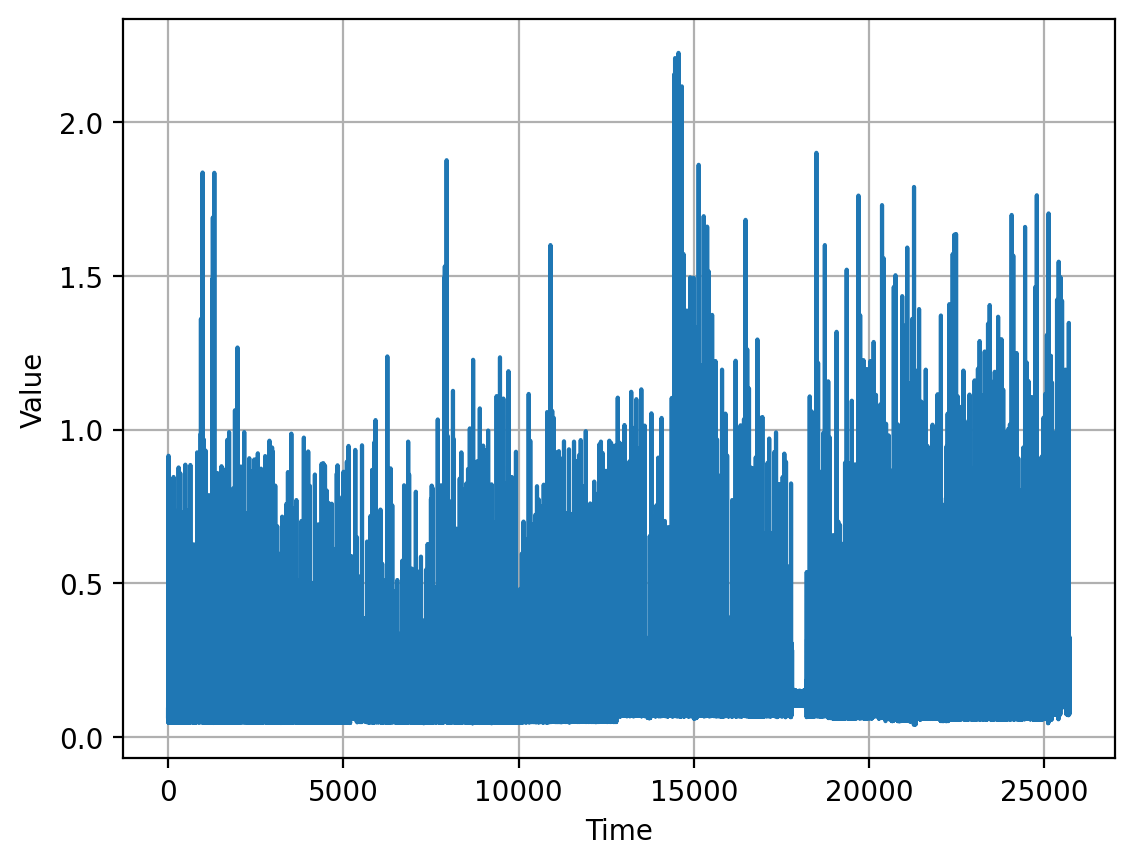

client  0


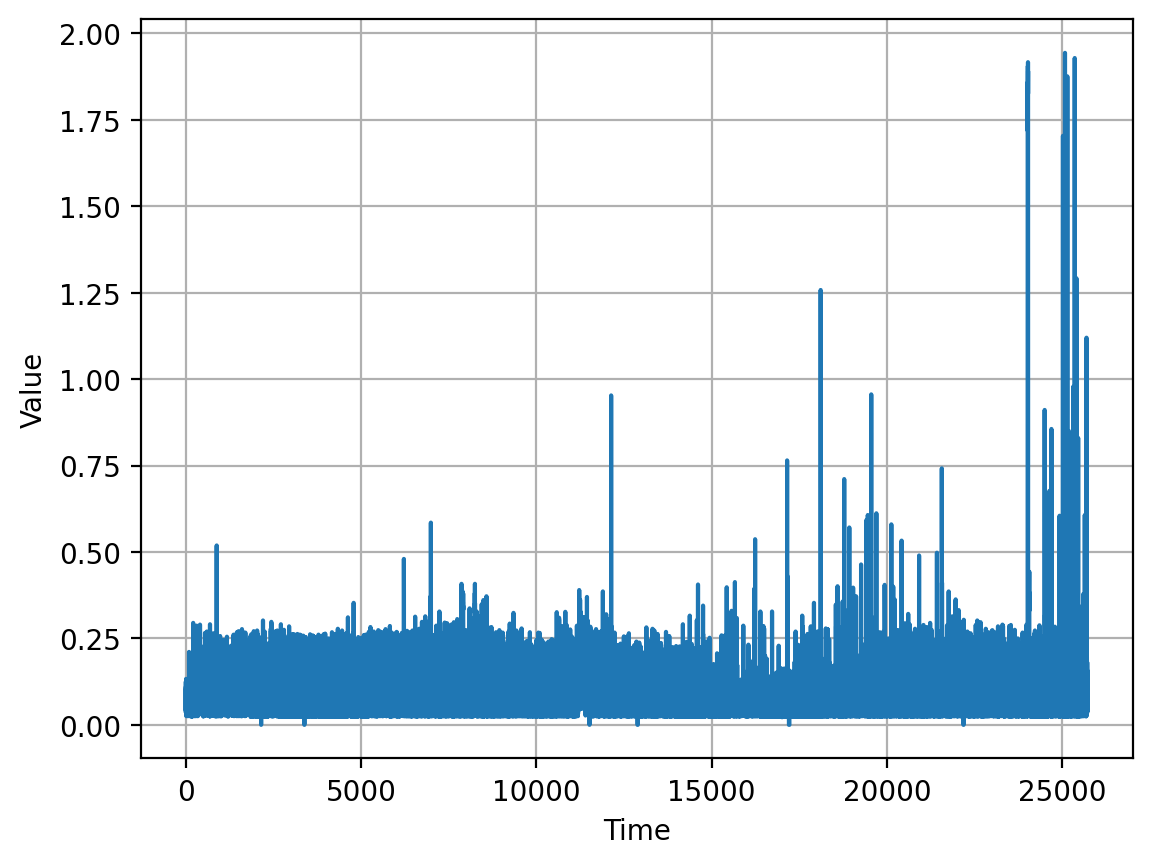

client  1


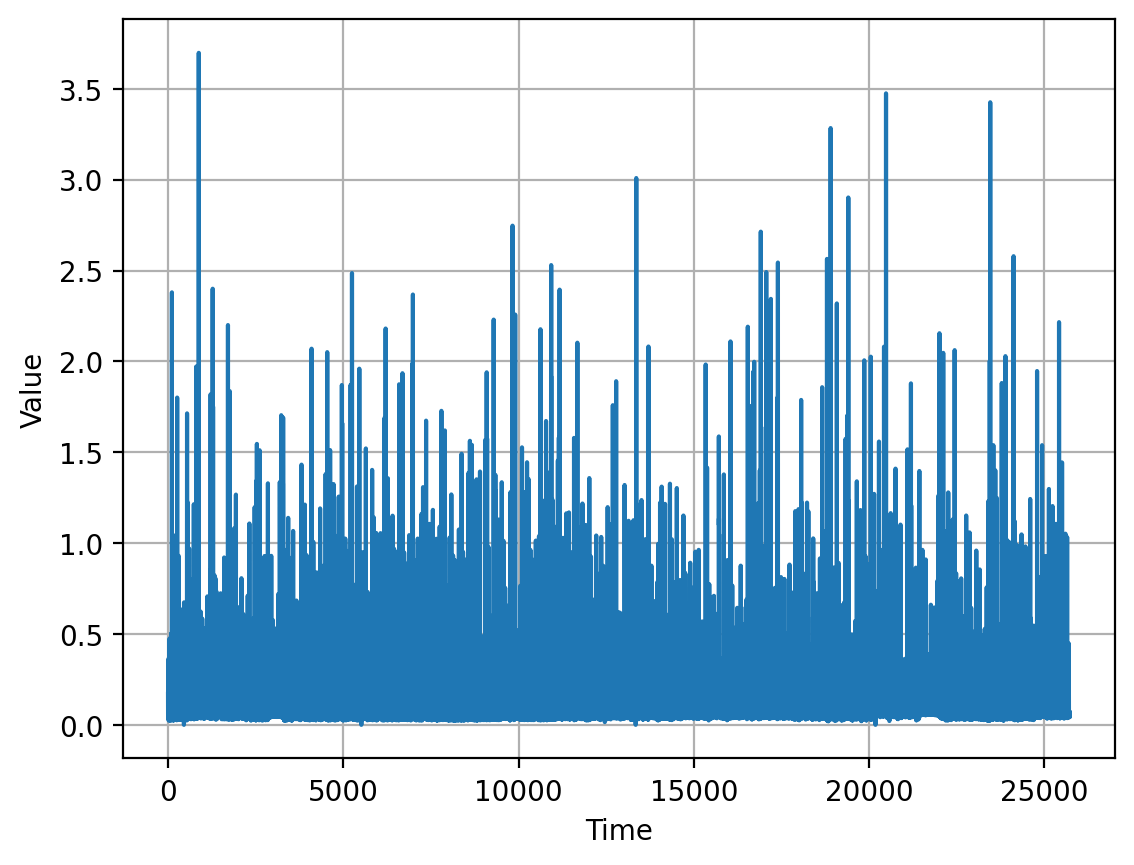

client  2


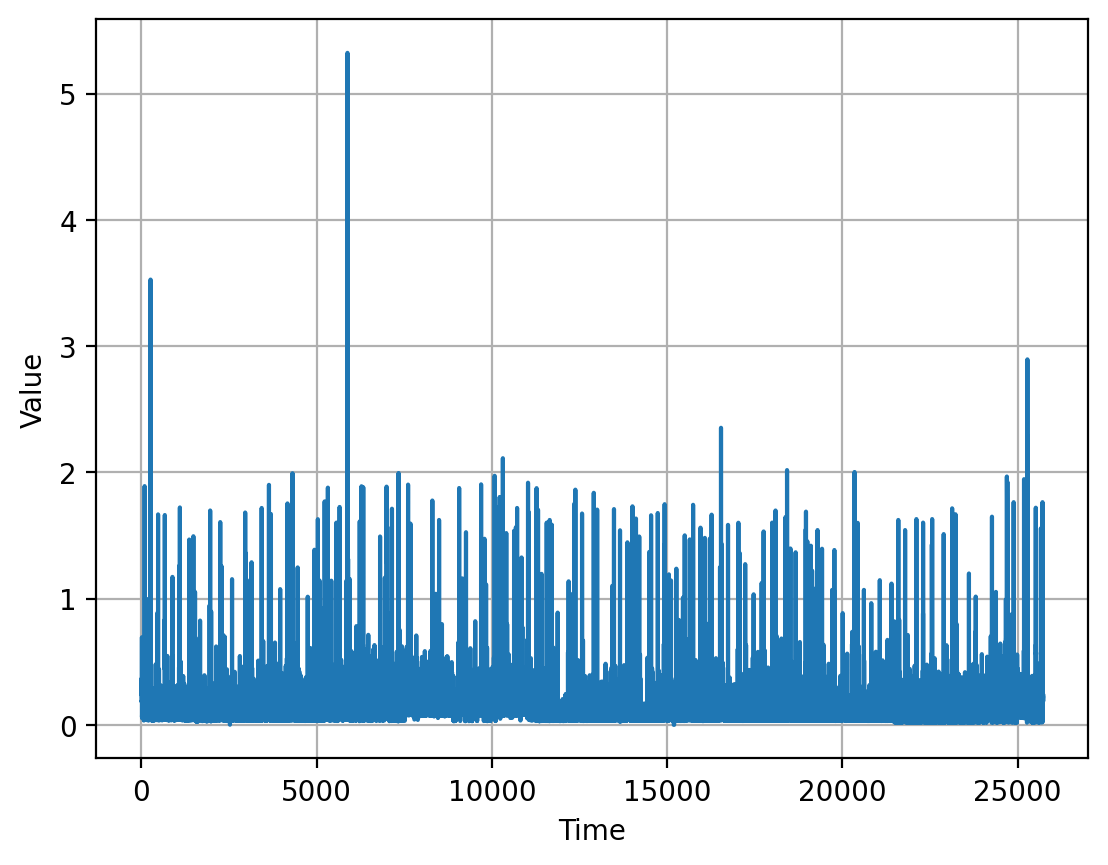

client  3


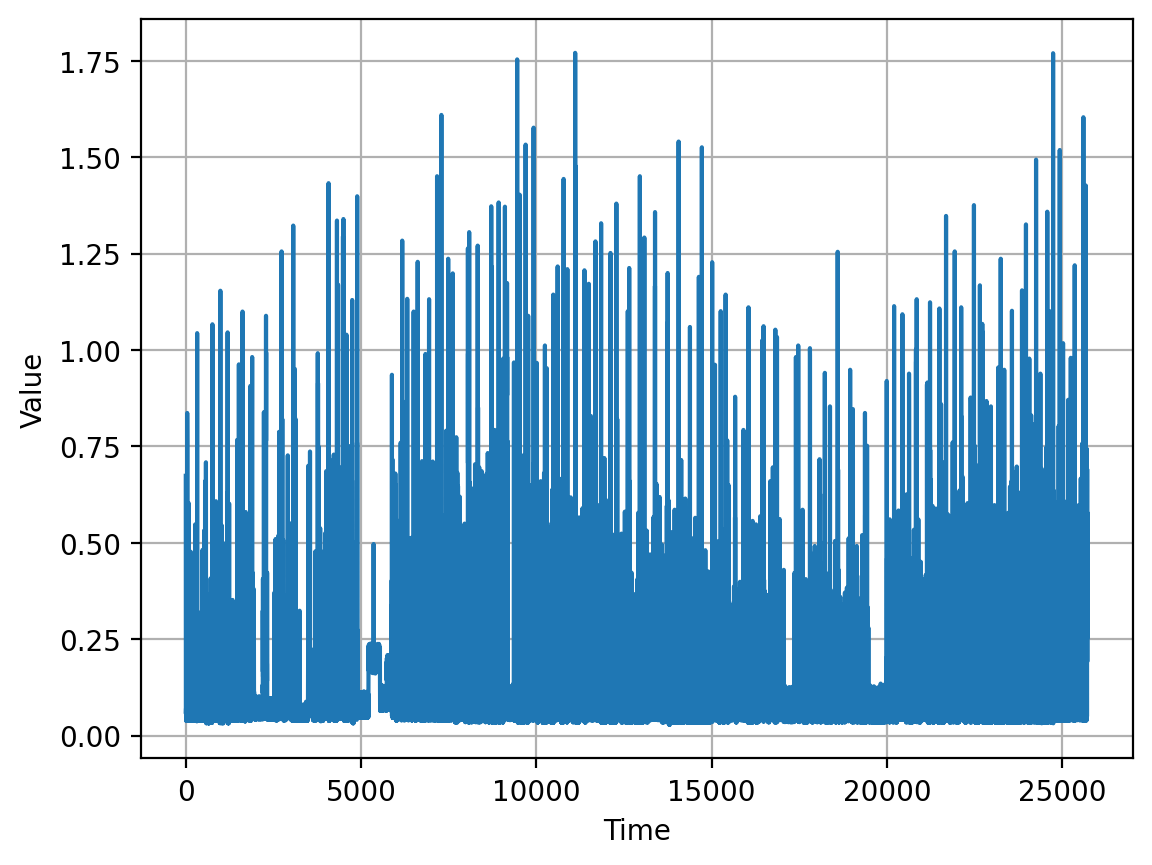

client  4


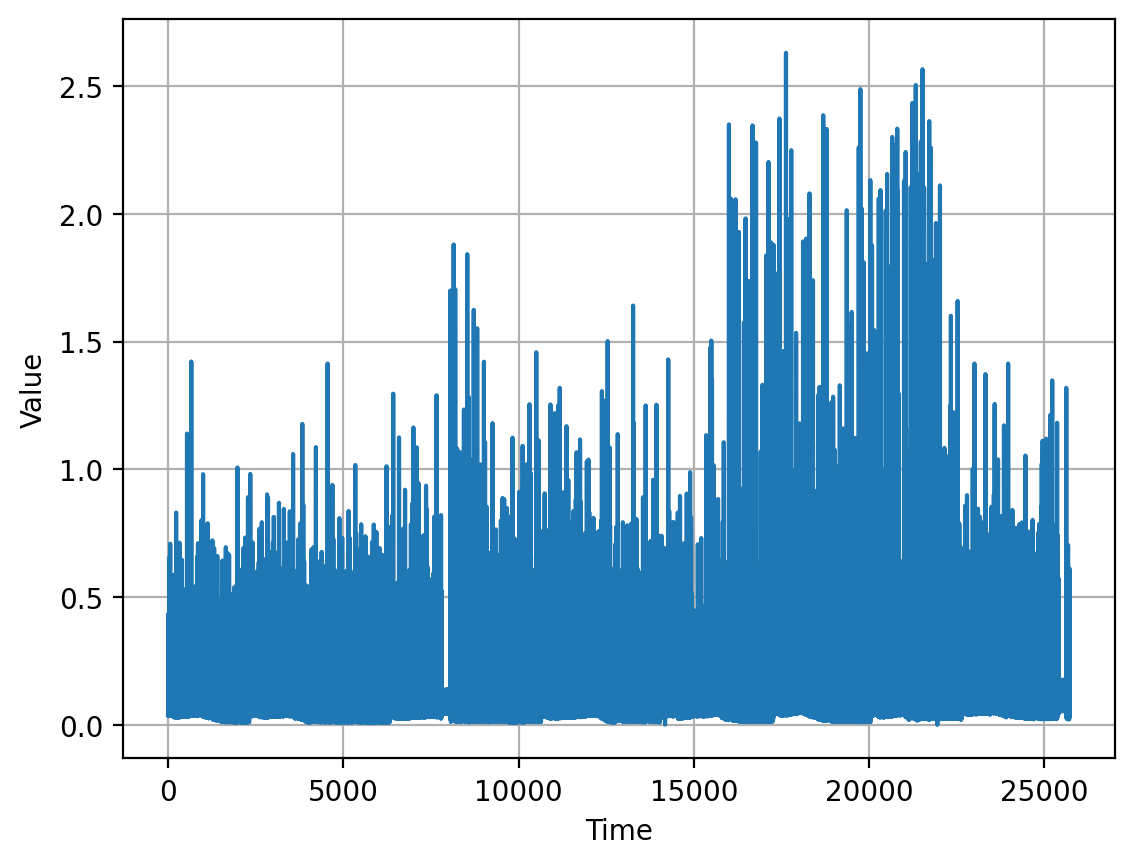

client  5


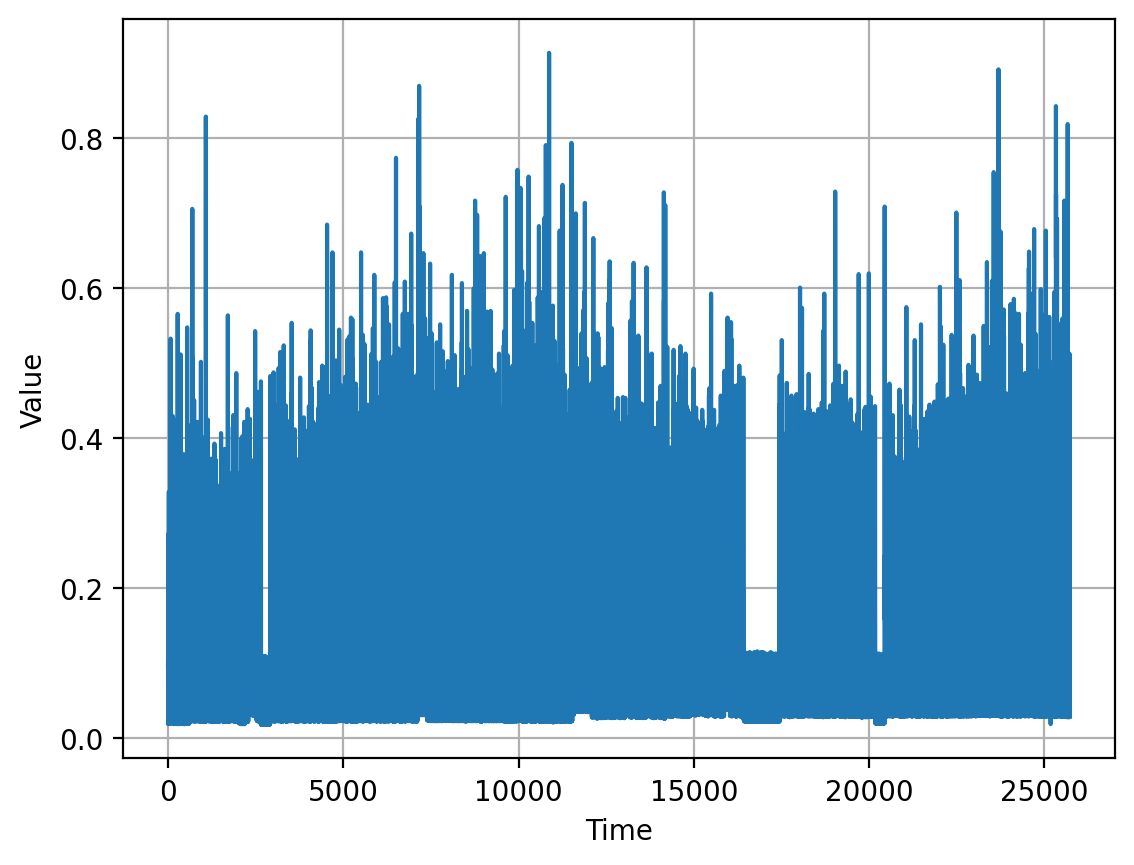

client  6


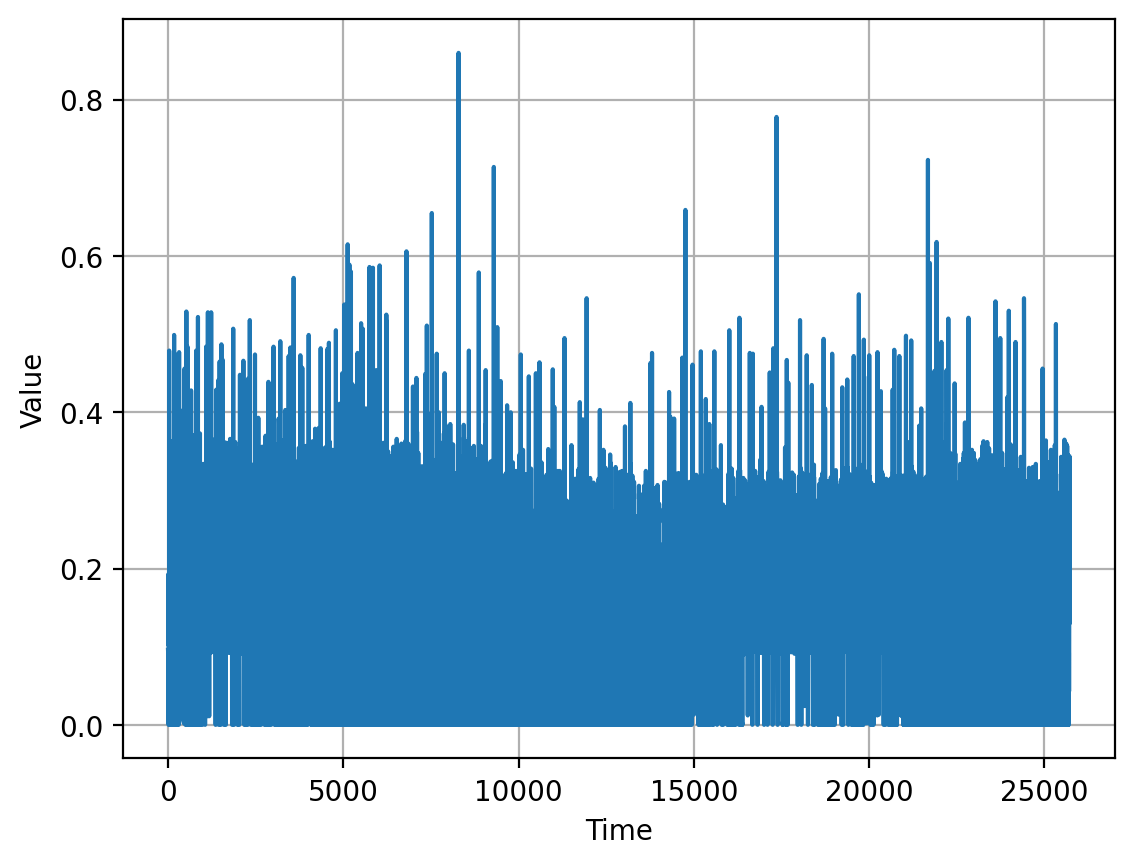

client  7


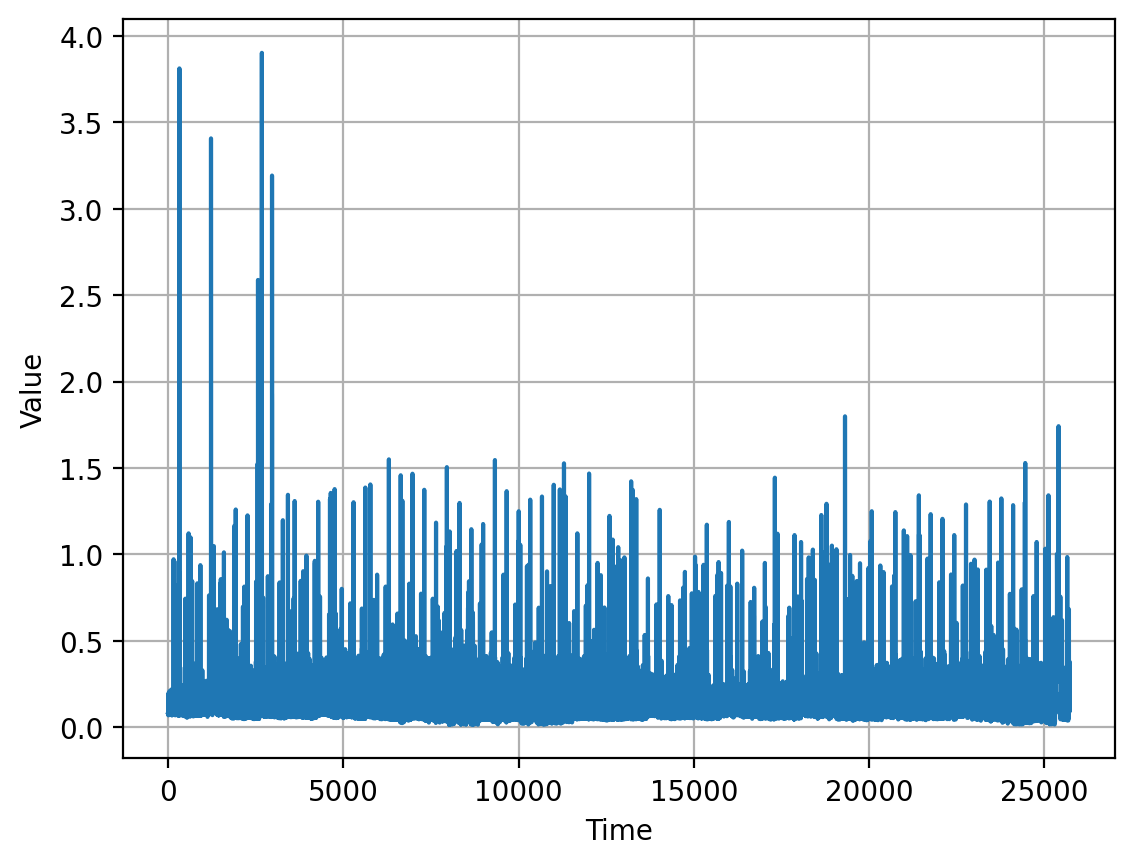

client  8


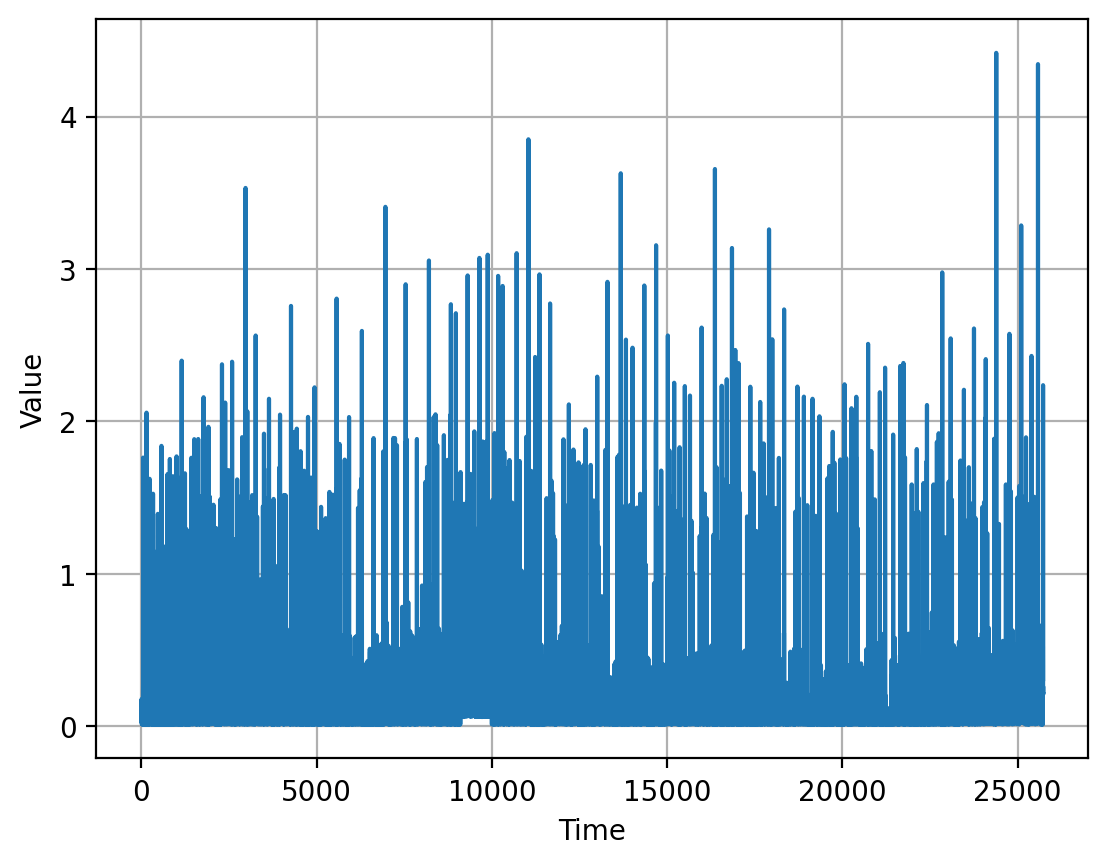

client  9


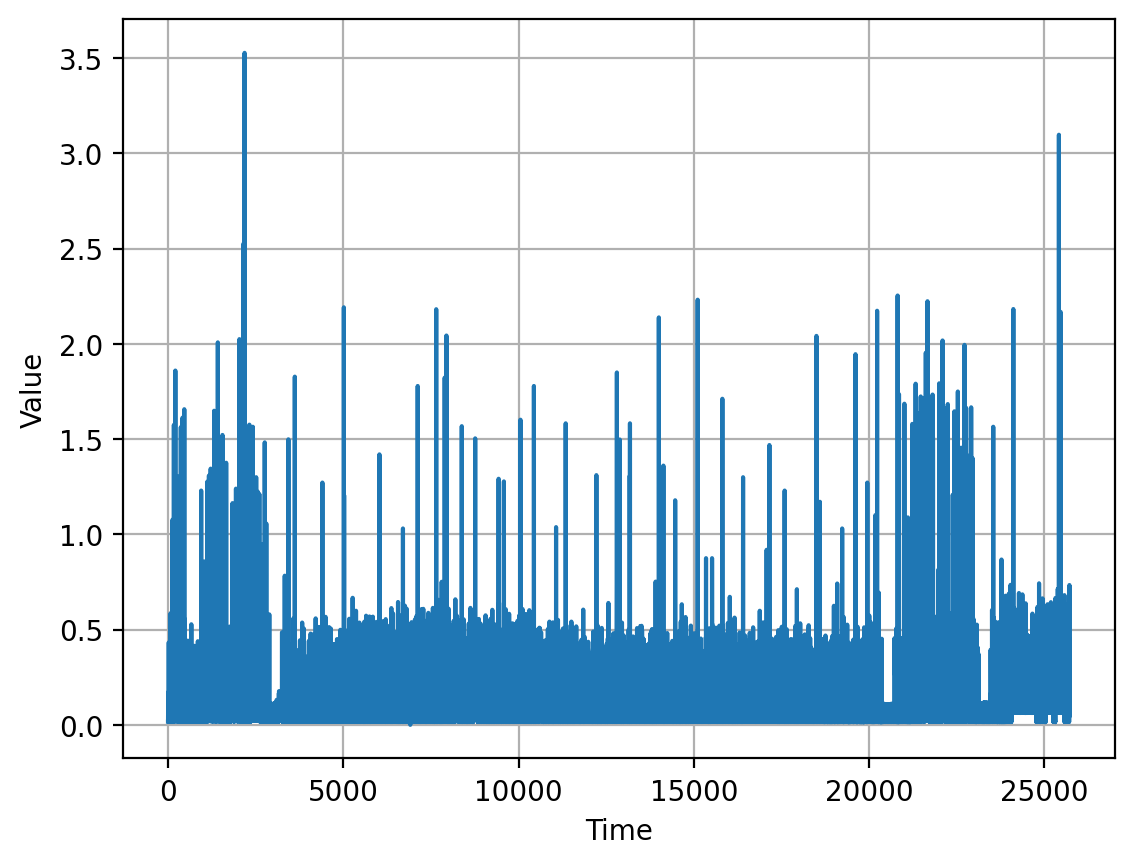

client 10


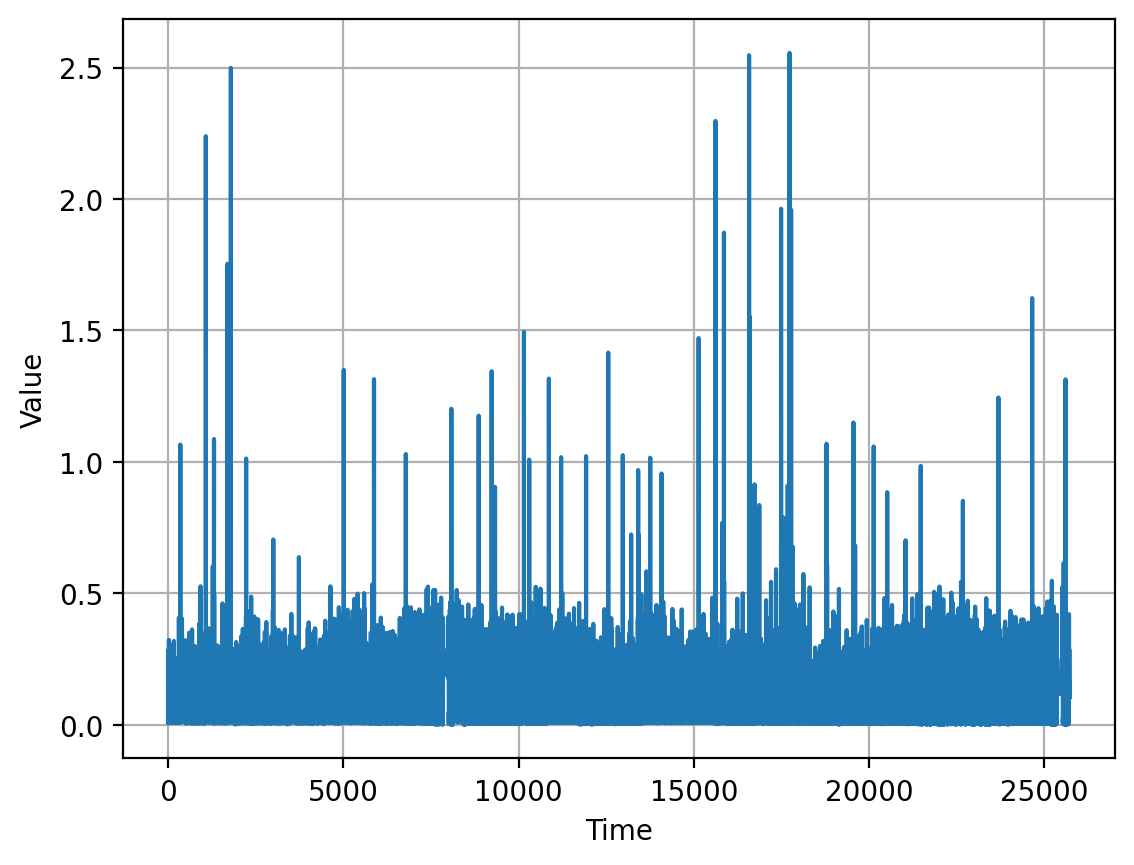

client 11


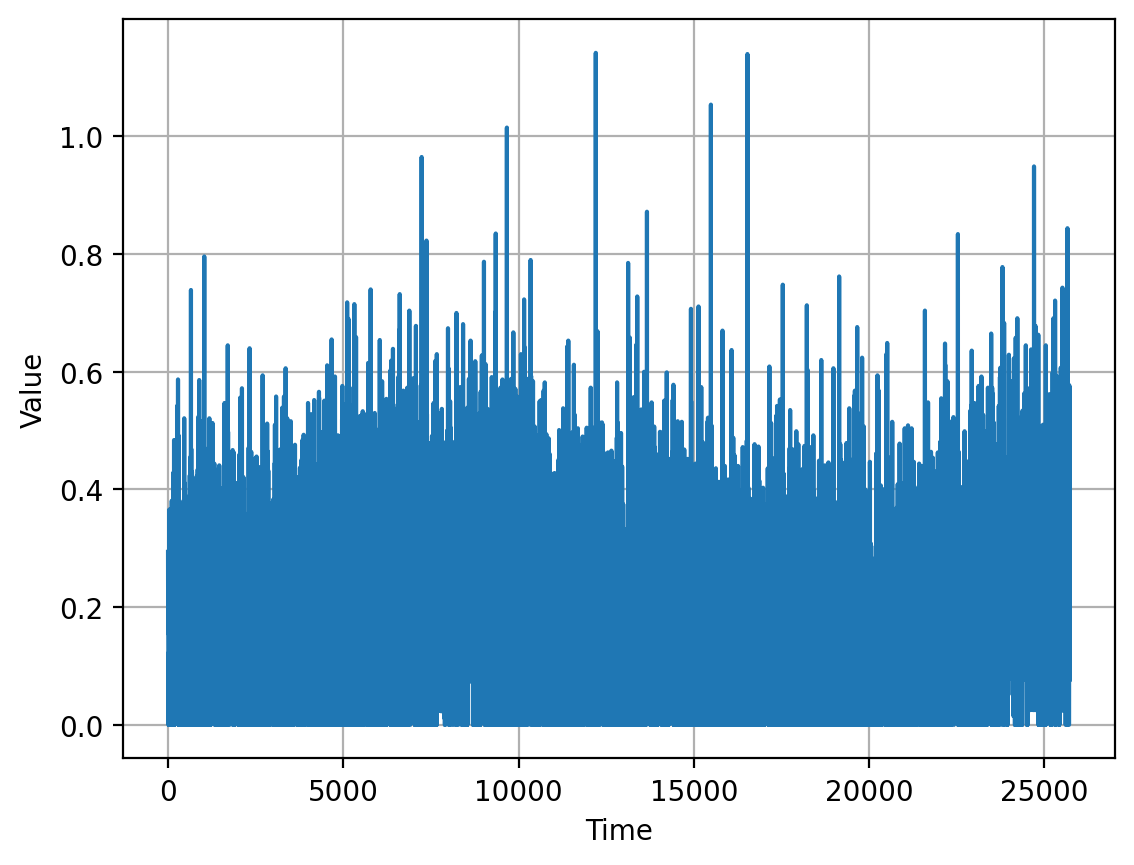

client 12


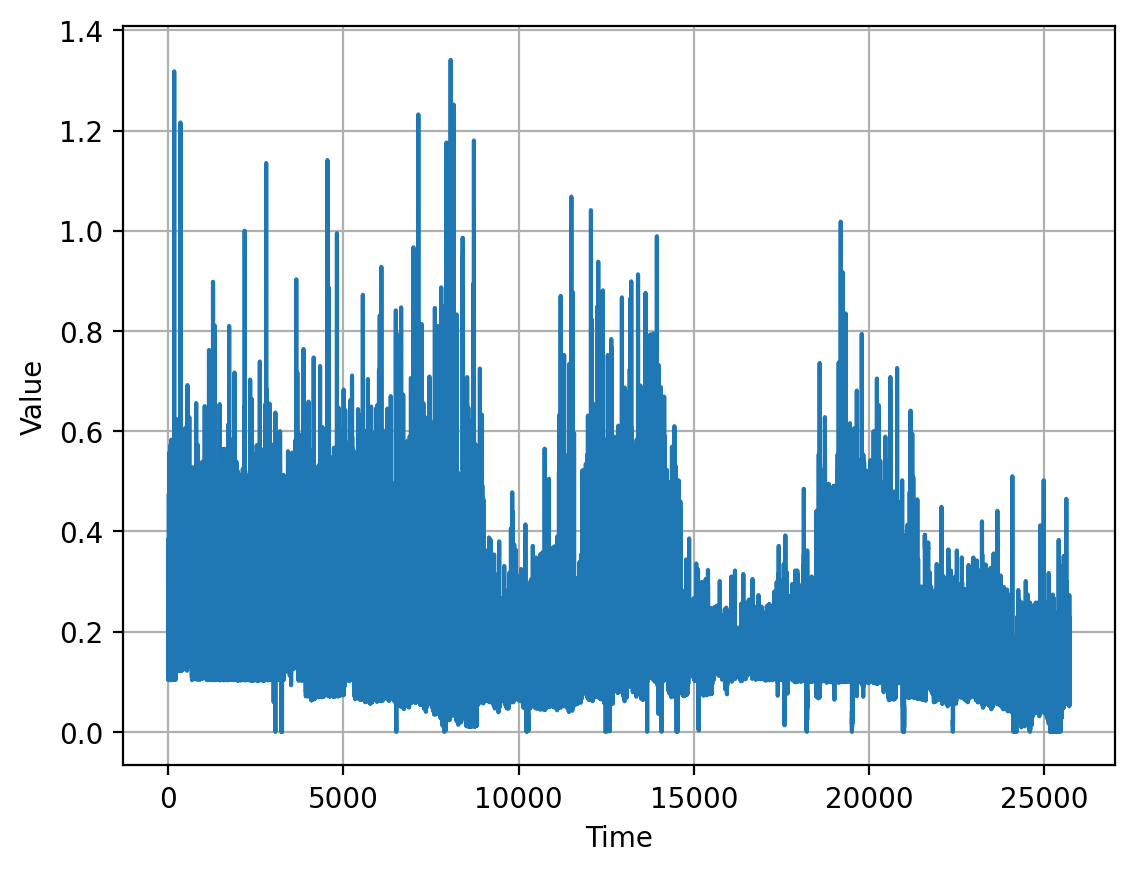

client 13


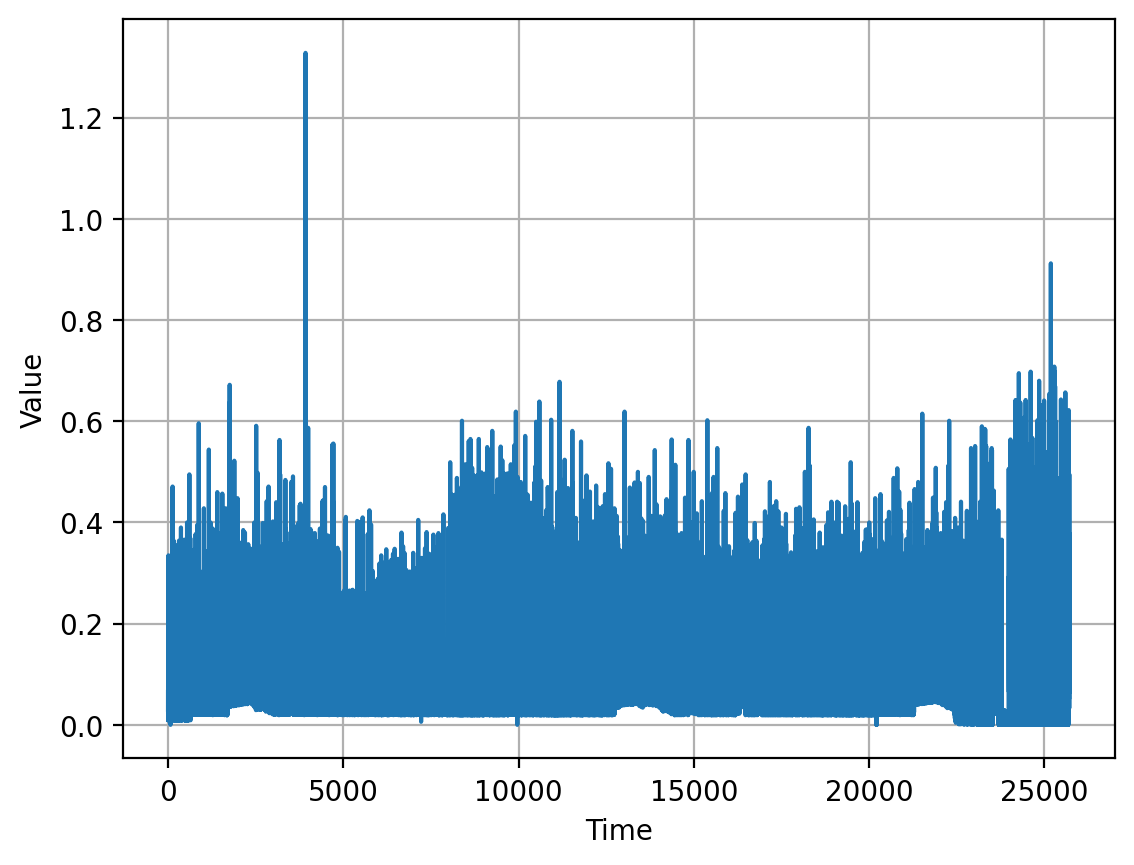

client 14


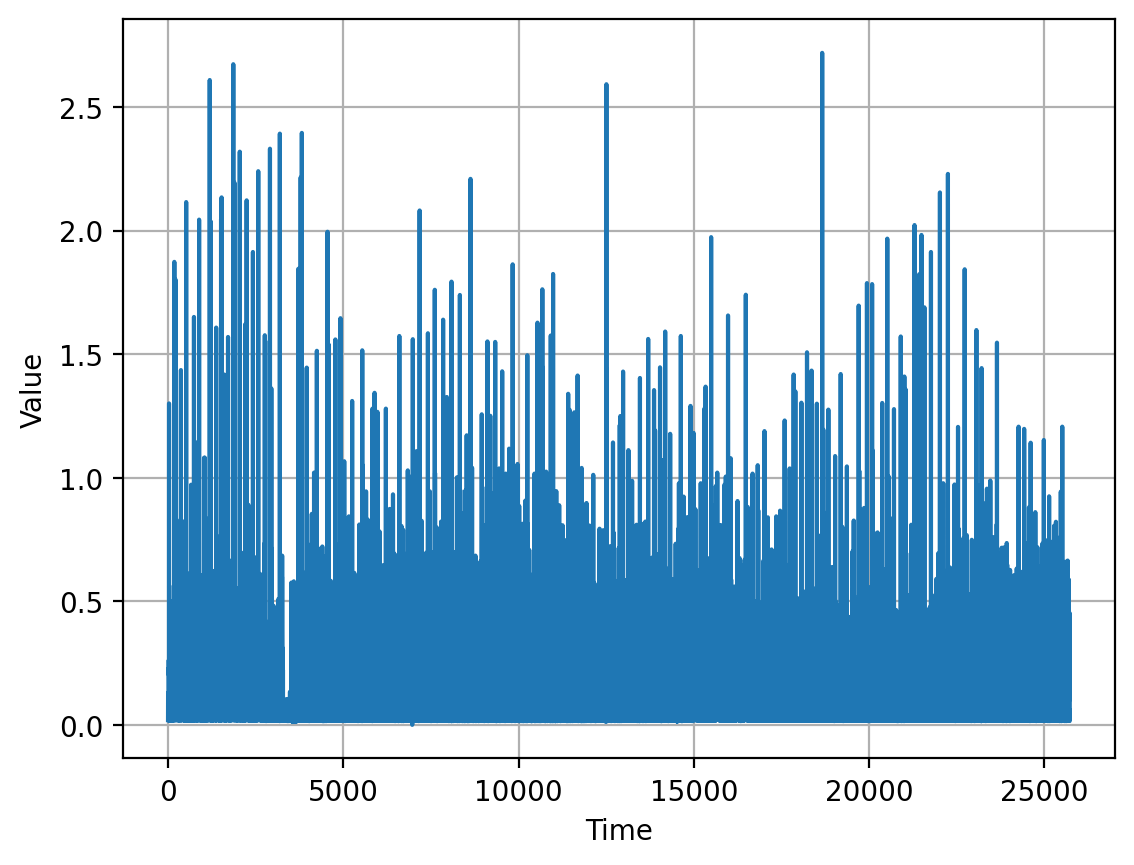

client 15


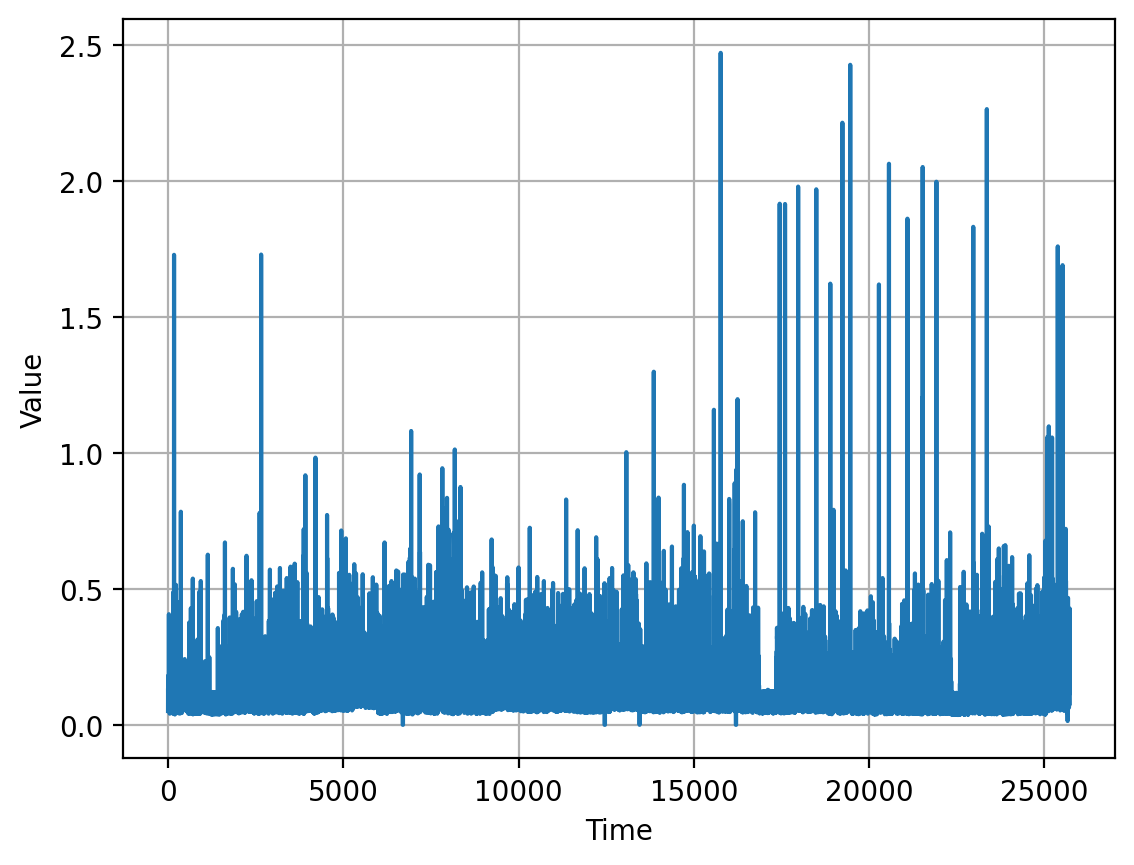

client 16


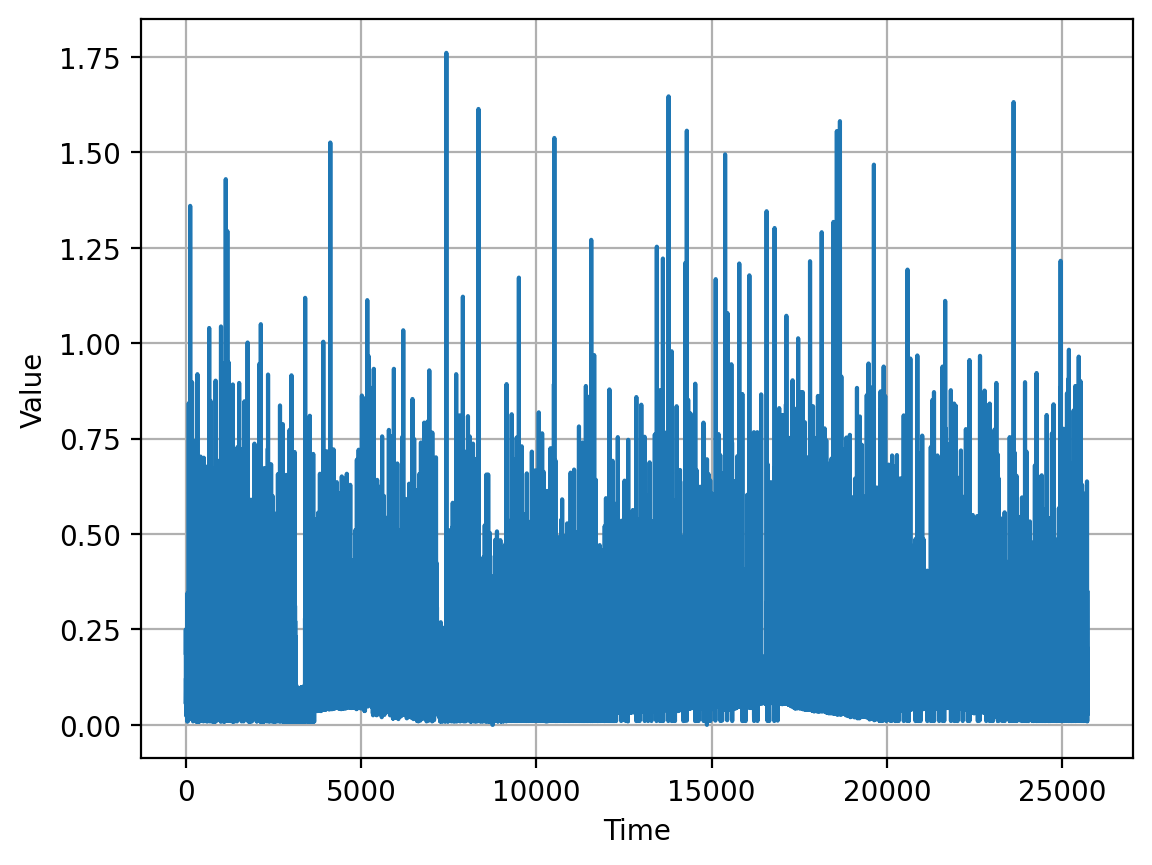

client 17


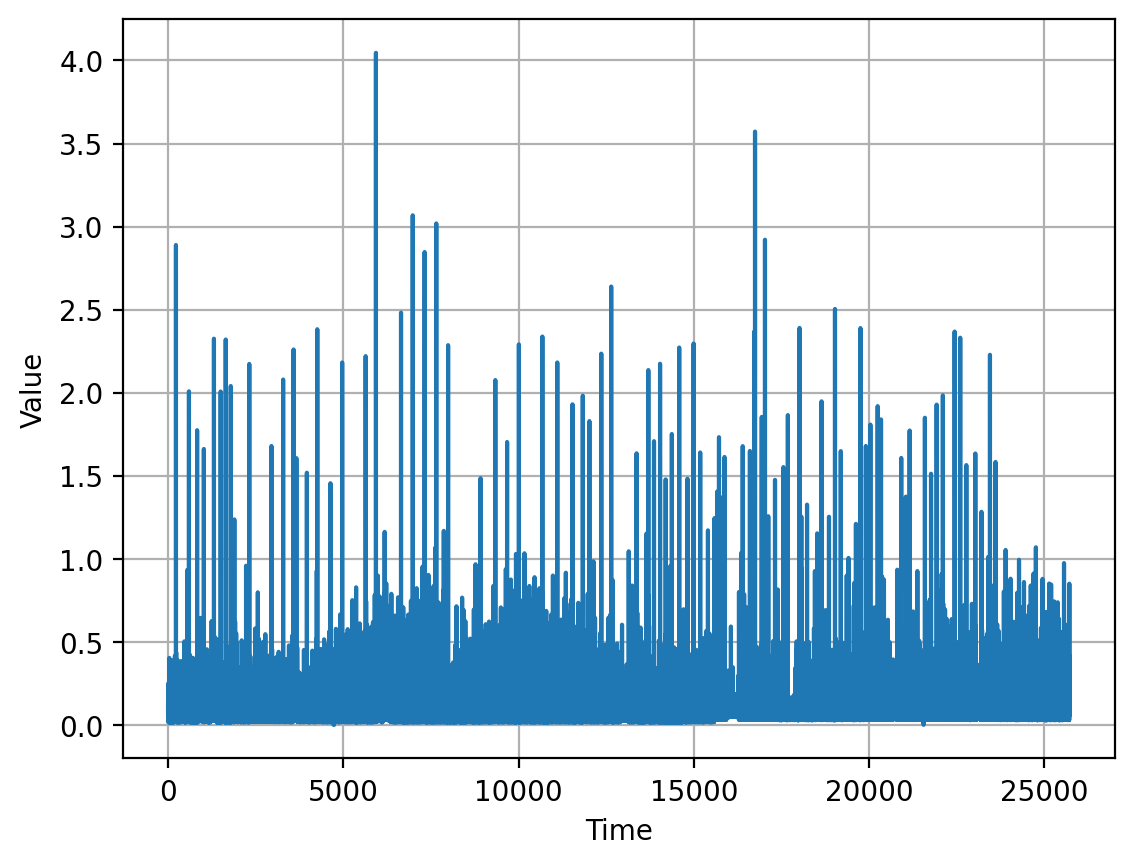

client 18


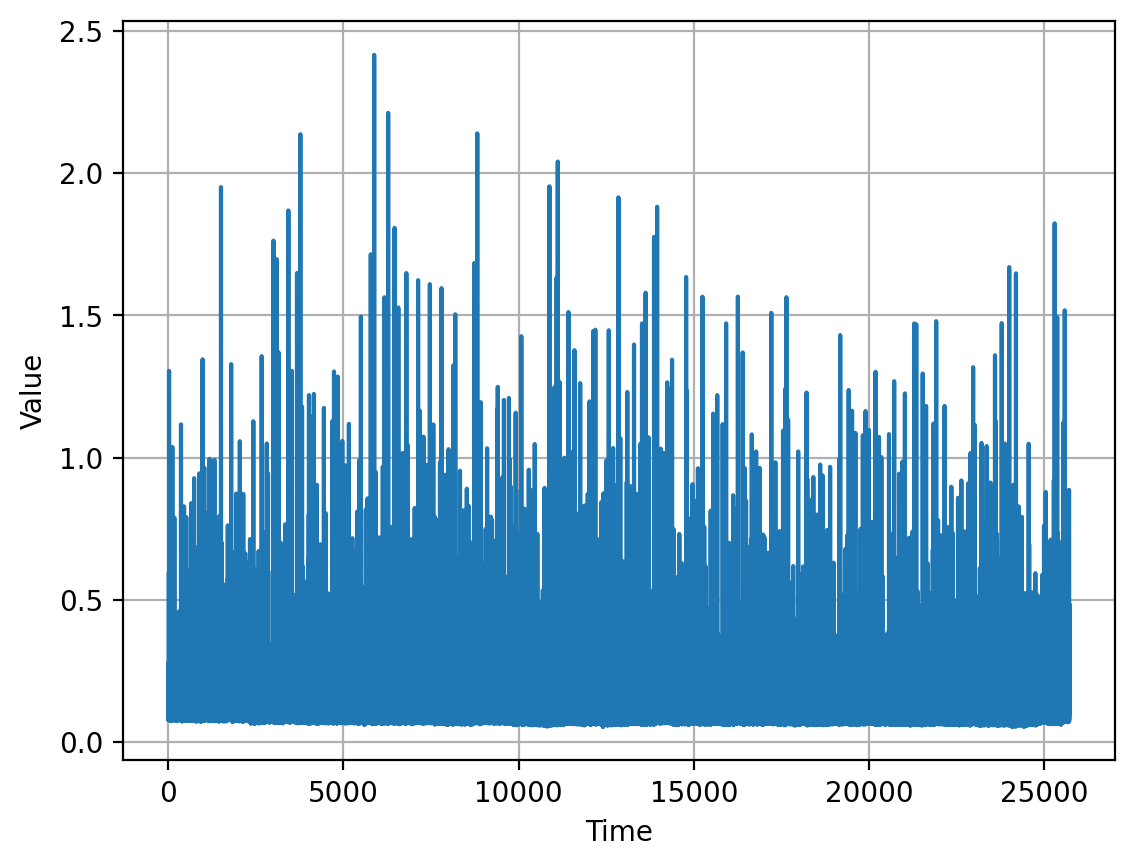

client 19


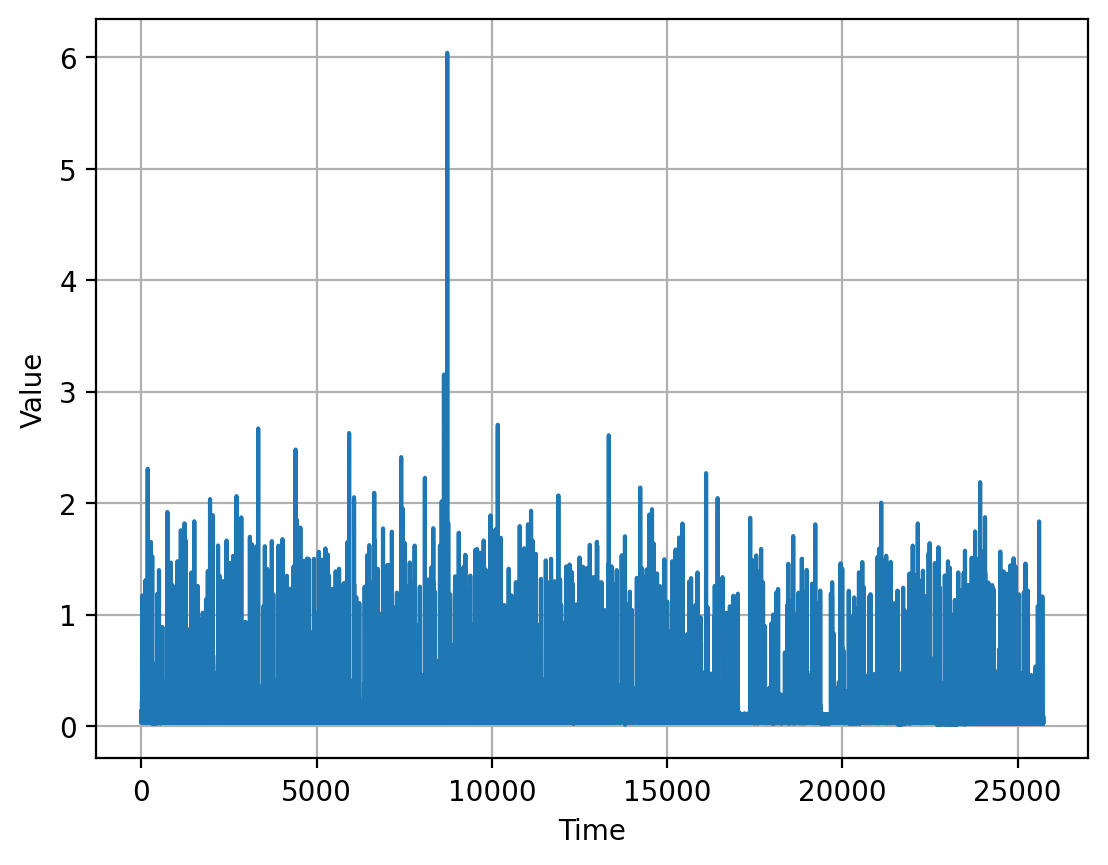

client 20


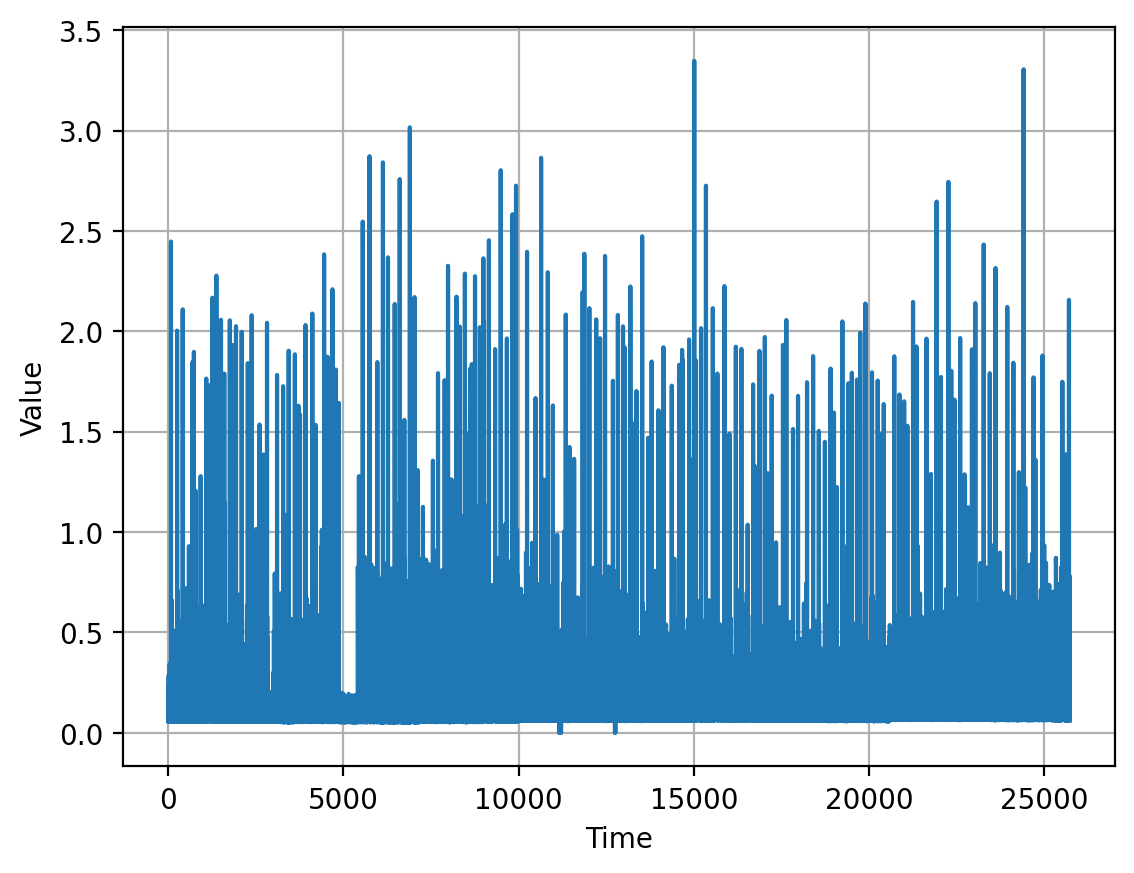

client 21


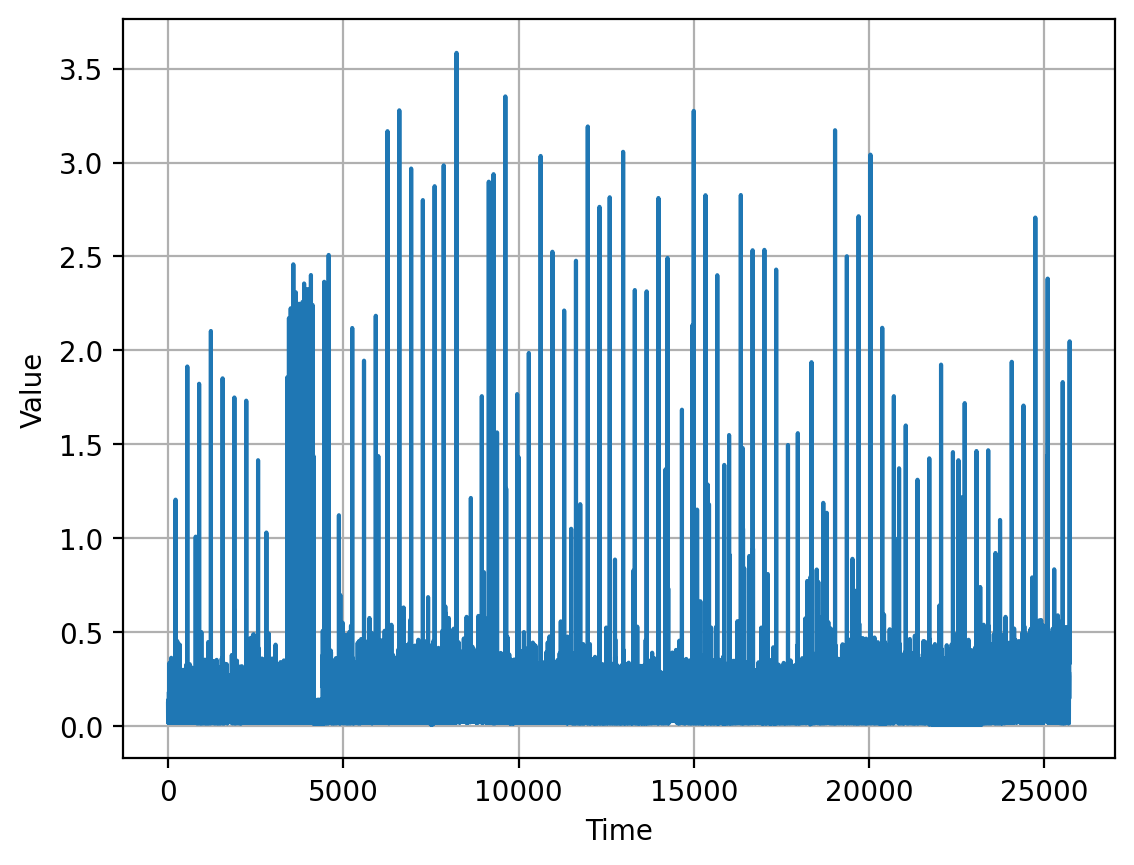

client 22


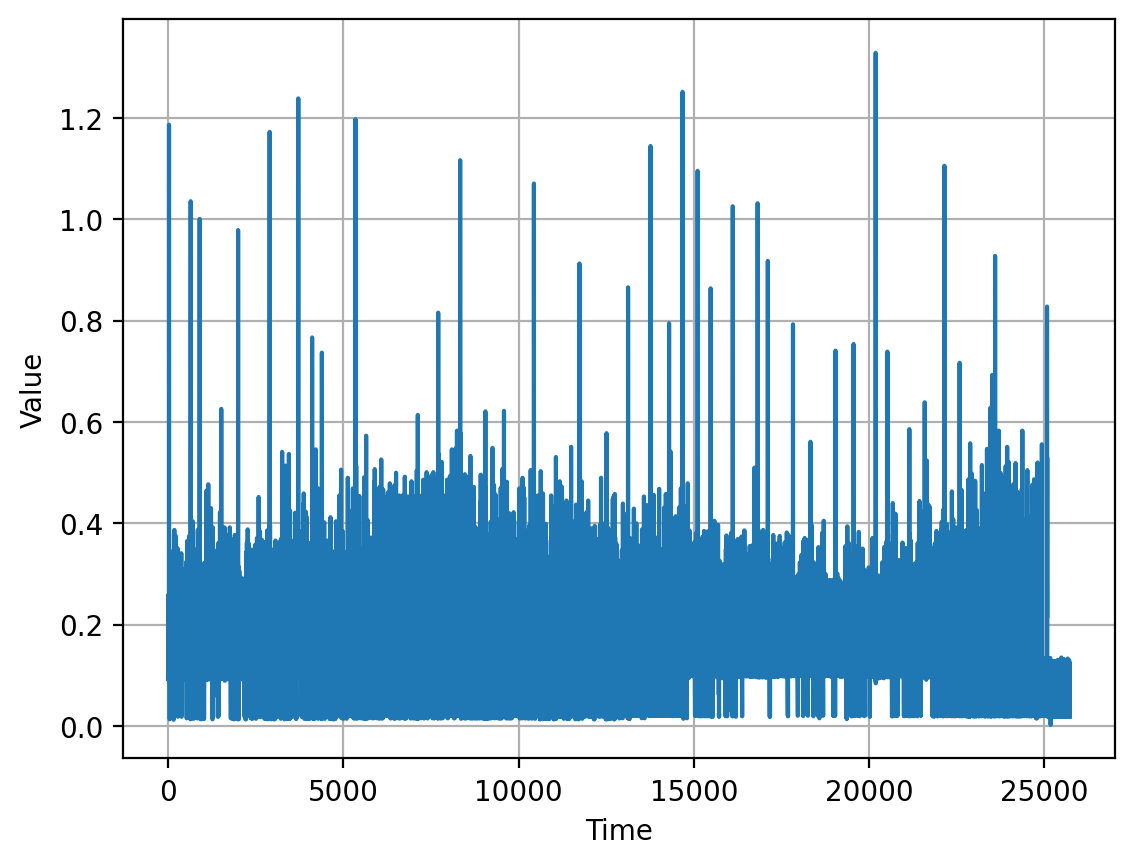

client 23


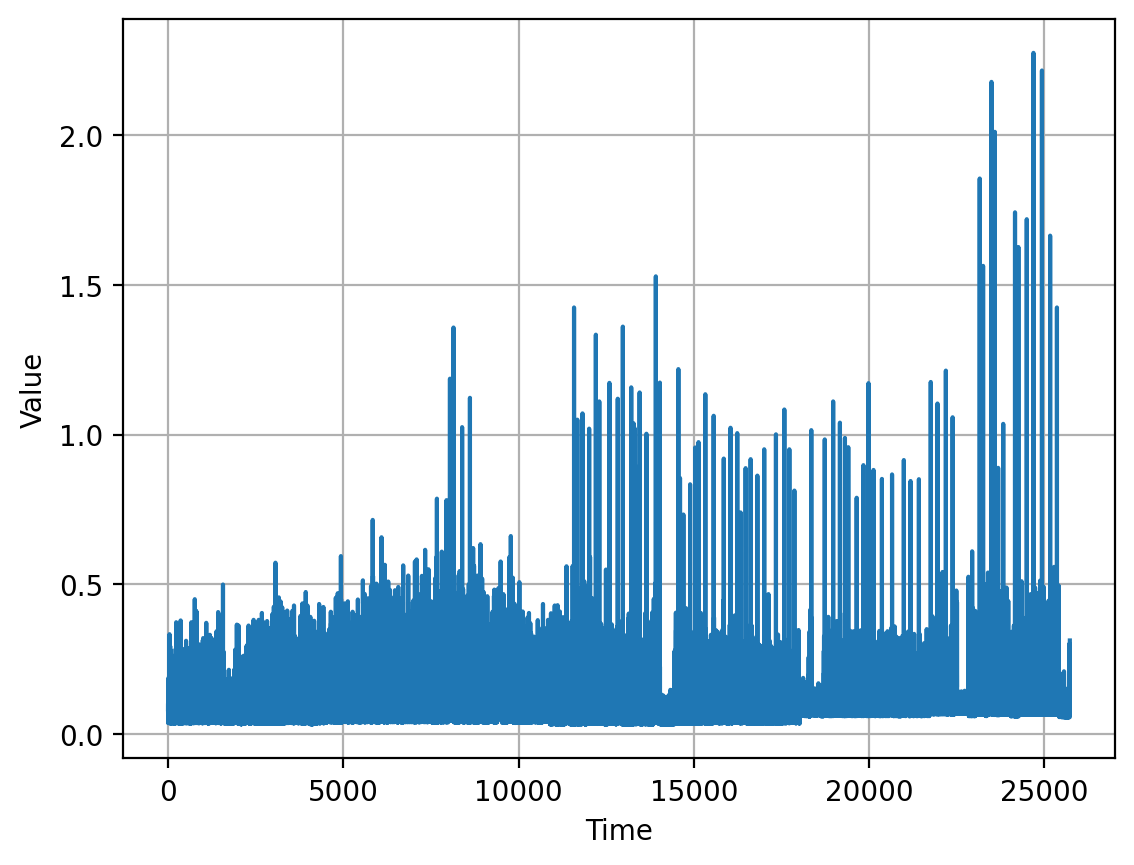

client 24


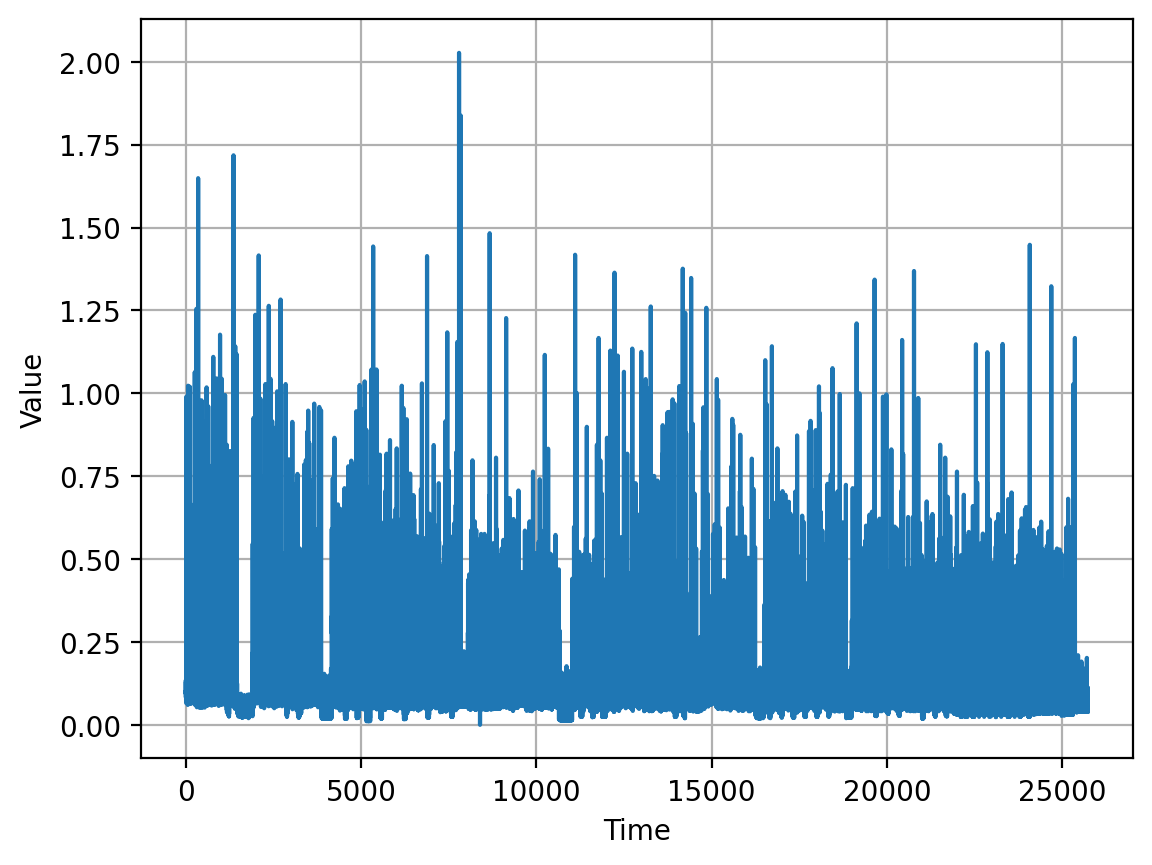

client 25


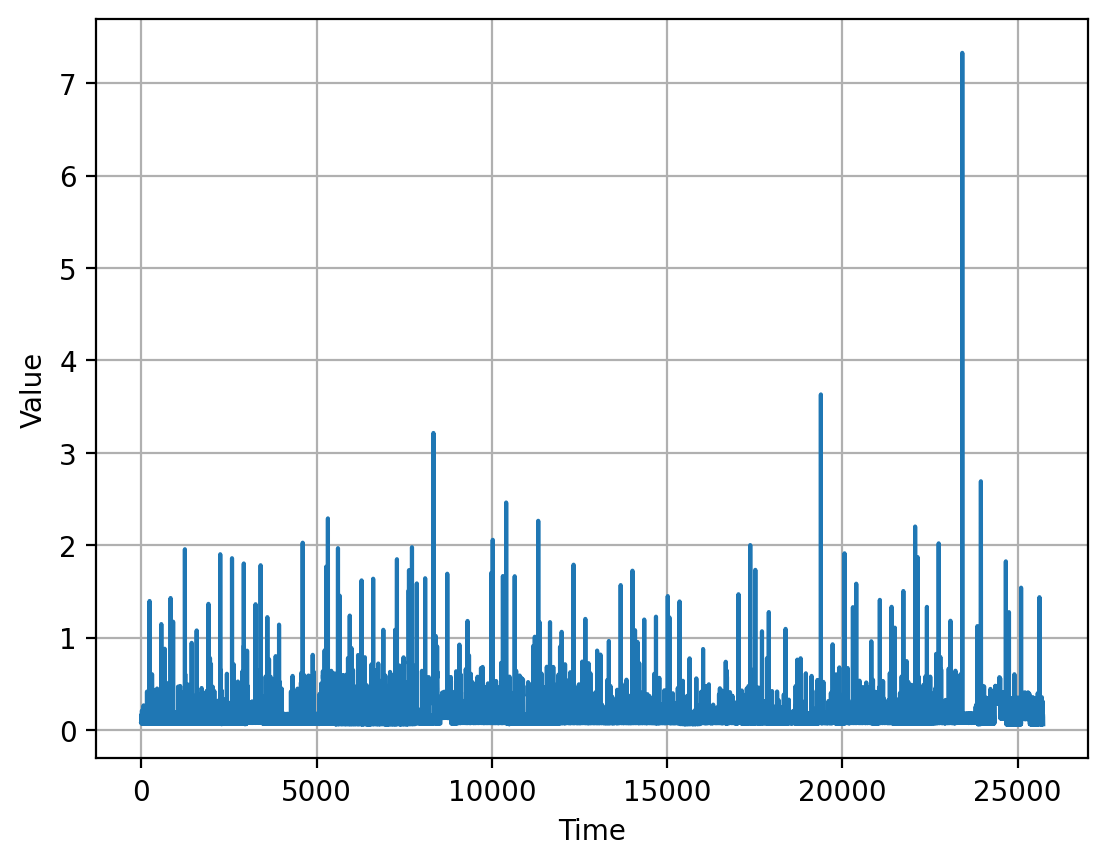

client 26


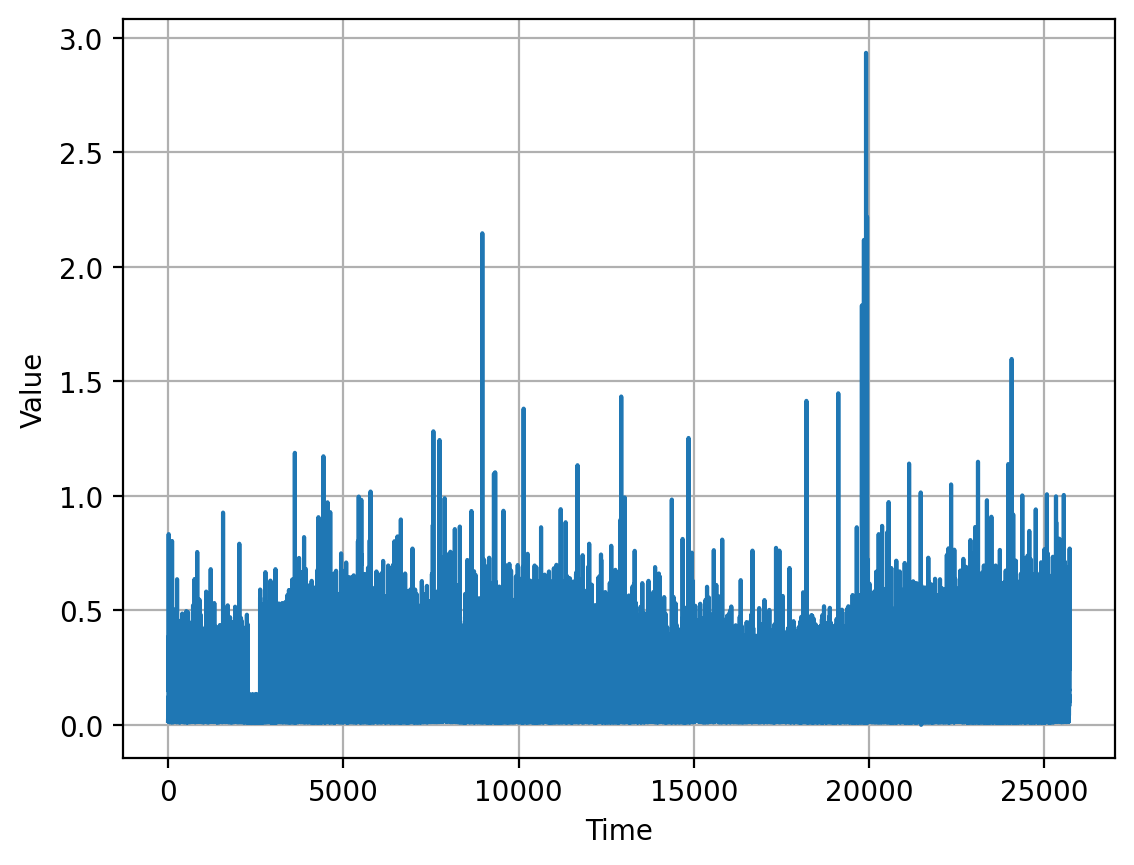

client 27


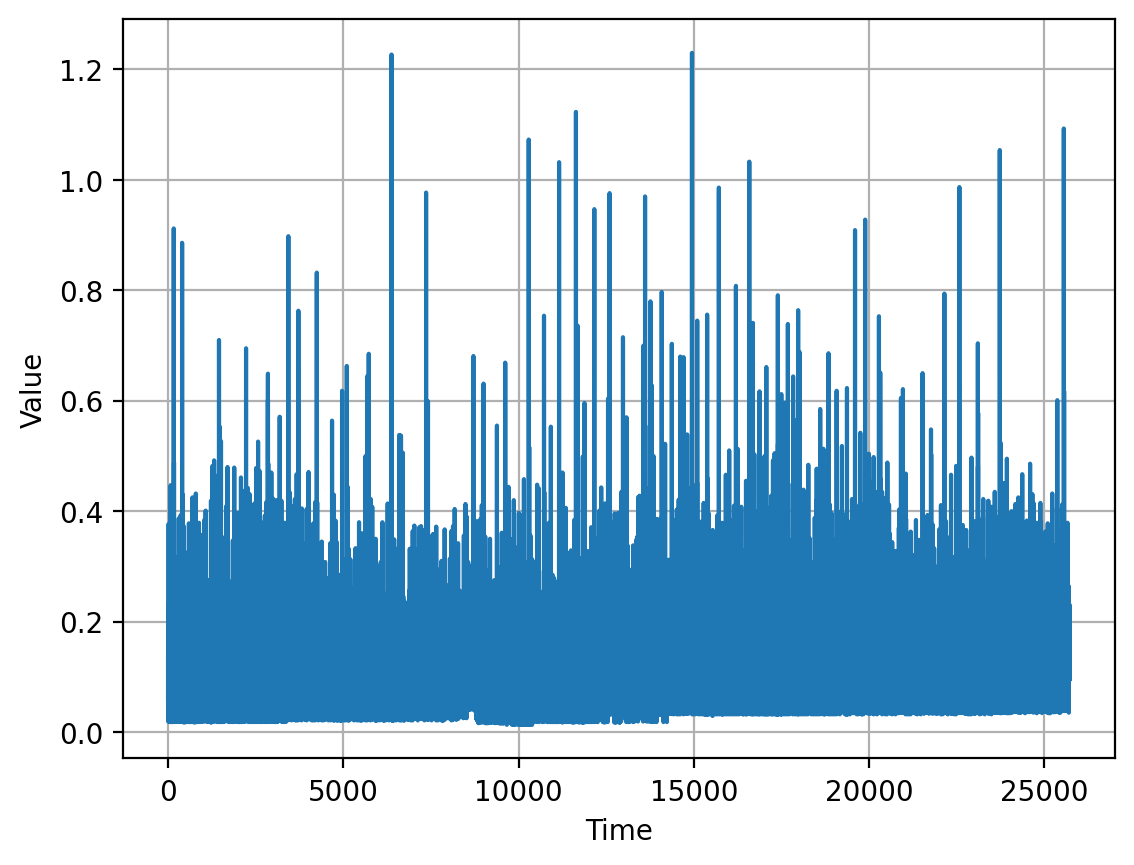

client 28


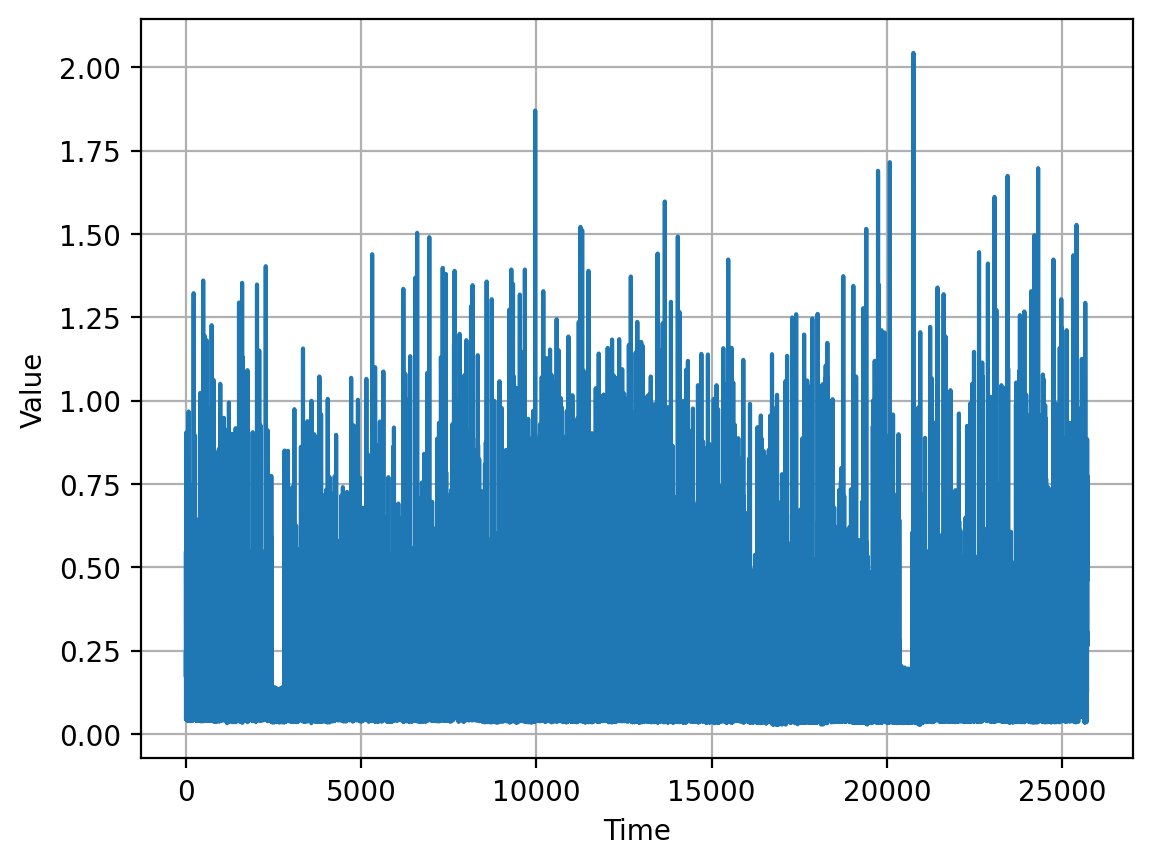

client 29


<Figure size 640x480 with 0 Axes>

In [9]:
for i in range(0, 30):
  plot_series(range(0, len(consumption[0])), consumption[i])
  plt.show()
  print('client {:2d}'.format(i))

  plt.clf()

In [10]:
percentile = np.percentile(consumption, [0, 25, 50, 75, 100])
IQR = percentile[3] - percentile[1]
# increase the whisker to 3 instead of 1.5
UPL = percentile[3] + IQR*3
DNL = percentile[1] - IQR*3


In [11]:
out_up = [0 for i in range(30)]
out_dn = [0 for i in range(30)]
for i in range(0, 30):
  for j in range(0, len(consumption[i])):
    if consumption[i][j] > UPL:
      consumption[i][j] = UPL
      out_up[i] = out_up[i] + 1
    elif consumption[i][j] < DNL:
      consumption[i][j] = DNL
      out_dn[i] = out_dn[i] + 1


# Create Training set

In [12]:
length = len(date[0])
split = int(0.8*length)

train_raw = [x[0: split] for x in consumption]
test_raw = [x[split: ] for x in consumption]

In [13]:
def create_dataset_central(data, time_step):
  x_data, y_data = [], []
  for i in range(len(data) - time_step):
    x = data[i: (i + time_step)]
    x_data.append(x)
    y = [data[i + time_step]]
    y_data.append(y)
  x_data = np.array(x_data)
  y_data = np.array(y_data)
  return x_data, y_data

In [14]:
def create_dataset_fed(data, time_step):
  x_nest, y_nest = [], []
  for j in range(len(data)):
    x_data, y_data = [], []
    for i in range(len(data[j]) - time_step):
      x = data[j][i: (i + time_step)]
      x_data.append(x)
      y = [data[j][i + time_step]]
      y_data.append(y)

    x_data = np.array(x_data)[:, :, np.newaxis]
    x_nest.append(x_data)
    y_nest.append(y_data)
  x_nest = np.array(x_nest)  
  return [tf.data.Dataset.from_tensor_slices((x_nest[x], np.array(y_nest[x]))) for x in range(len(x_nest))]

In [15]:
time_step = 48
train_data_fed = create_dataset_fed(train_raw, time_step)
test_data_fed = create_dataset_fed(test_raw, time_step)

2022-10-04 13:53:54.258058: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-04 13:53:54.258097: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-04 13:53:54.258127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-04 13:53:54.258156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-10-04 13:53:54.258186: W tensorfl

In [16]:
example_dataset = train_data_fed[0]
example_element = next(iter(example_dataset))

In [17]:
num_epochs = 10
batch_size = 48
shuffle_buffer = 100
prefetch_buffer = 10

def preprocess_train(dataset):
  def batch_format_fn(x_d, y_d):
    return OrderedDict(
        x=x_d,
        y=tf.reshape(y_d, [-1, 1])
    )
  return dataset.repeat(num_epochs).shuffle(shuffle_buffer, seed=1).batch(
      batch_size).map(batch_format_fn).prefetch(prefetch_buffer)  

def preprocess_test(dataset):
  def batch_format_fn(x_d, y_d):
    return OrderedDict(
        x=x_d,
        y=tf.reshape(y_d, [-1, 1])
    )
  return dataset.batch(batch_size).map(batch_format_fn).prefetch(prefetch_buffer)

In [18]:
preprocess_example = preprocess_train(example_dataset)

In [19]:
train_set_fed = [preprocess_train(train_data_fed[i]) for i in range(len(train_raw))]
test_set_fed = [preprocess_test(test_data_fed[i]) for i in range(len(test_raw))]

train_set_central = train_set_fed[0]
test_set_central = test_set_fed[0]

# Train model

In [20]:
def create_DNN():
  return tf.keras.models.Sequential([
      keras.layers.Dense(48, activation='relu',
      #input_dim = 48),either use Drop layer or regularizer                   
      input_dim = 48, kernel_regularizer='l2'),  
      keras.layers.Dropout(0.1),
      keras.layers.Dense(42, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(1)
  ])

In [21]:
def model_fn():
  keras_model = create_DNN()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec = preprocess_example.element_spec,
      loss = tf.keras.losses.MeanSquaredError(),
      metrics = [tf.keras.metrics.MeanSquaredError()]
  )

In [22]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: keras.optimizers.Adam(0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1)
)

logdir = "/tmp/logs/scalars/training"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()

In [23]:
num_rounds = 10
fed_metrics = [[] for i in range(0, num_rounds)]

start_time = time.time()
for i in range(0, num_rounds):
  state, metrics = iterative_process.next(state, train_set_fed)
  fed_metrics[i] = metrics
  print('round {:2d}, metrics={}'.format(i+1, metrics))

end_time = time.time()
train_time = end_time - start_time
print(train_time)

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('mean_squared_error', 0.0071572117), ('loss', 0.0071572117), ('num_examples', 6160200), ('num_batches', 128340)]))])
round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('mean_squared_error', 0.0069751656), ('loss', 0.0069751656), ('num_examples', 6160200), ('num_batches', 128340)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('mean_squared_error', 0.006967998), ('loss', 0.006967998), ('num_examples', 6160200), ('num_batches', 128340)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('mean_squared_error', 0.006991552), ('loss', 0.006991552), ('nu

In [24]:
evaluation = tff.learning.build_federated_evaluation(model_fn)
metrics = evaluation(state.model, test_set_fed)
print(metrics)

OrderedDict([('eval', OrderedDict([('mean_squared_error', 0.008580102), ('loss', 0.008580102), ('num_examples', 152940), ('num_batches', 3210)]))])


In [25]:
model_fed = create_DNN()
state.model.assign_weights_to(model_fed)

use this model to predict on individual dataset directly, like the central model

In [26]:
sample = tf.nest.map_structure(lambda x: x.numpy(), next(iter(test_set_fed[0])))

In [27]:
prediciton_fed = model_fed.predict(sample['x'])


2/2 [==============================] - 0s 1ms/step


In [28]:
print(f"MSE_fed: {mean_squared_error(prediciton_fed, sample['y'])}")
print(f"R2_fed: {r2_score(sample['y'], prediciton_fed)}")

MSE_fed: 0.007318892987228377
R2_fed: 0.2589305751185573


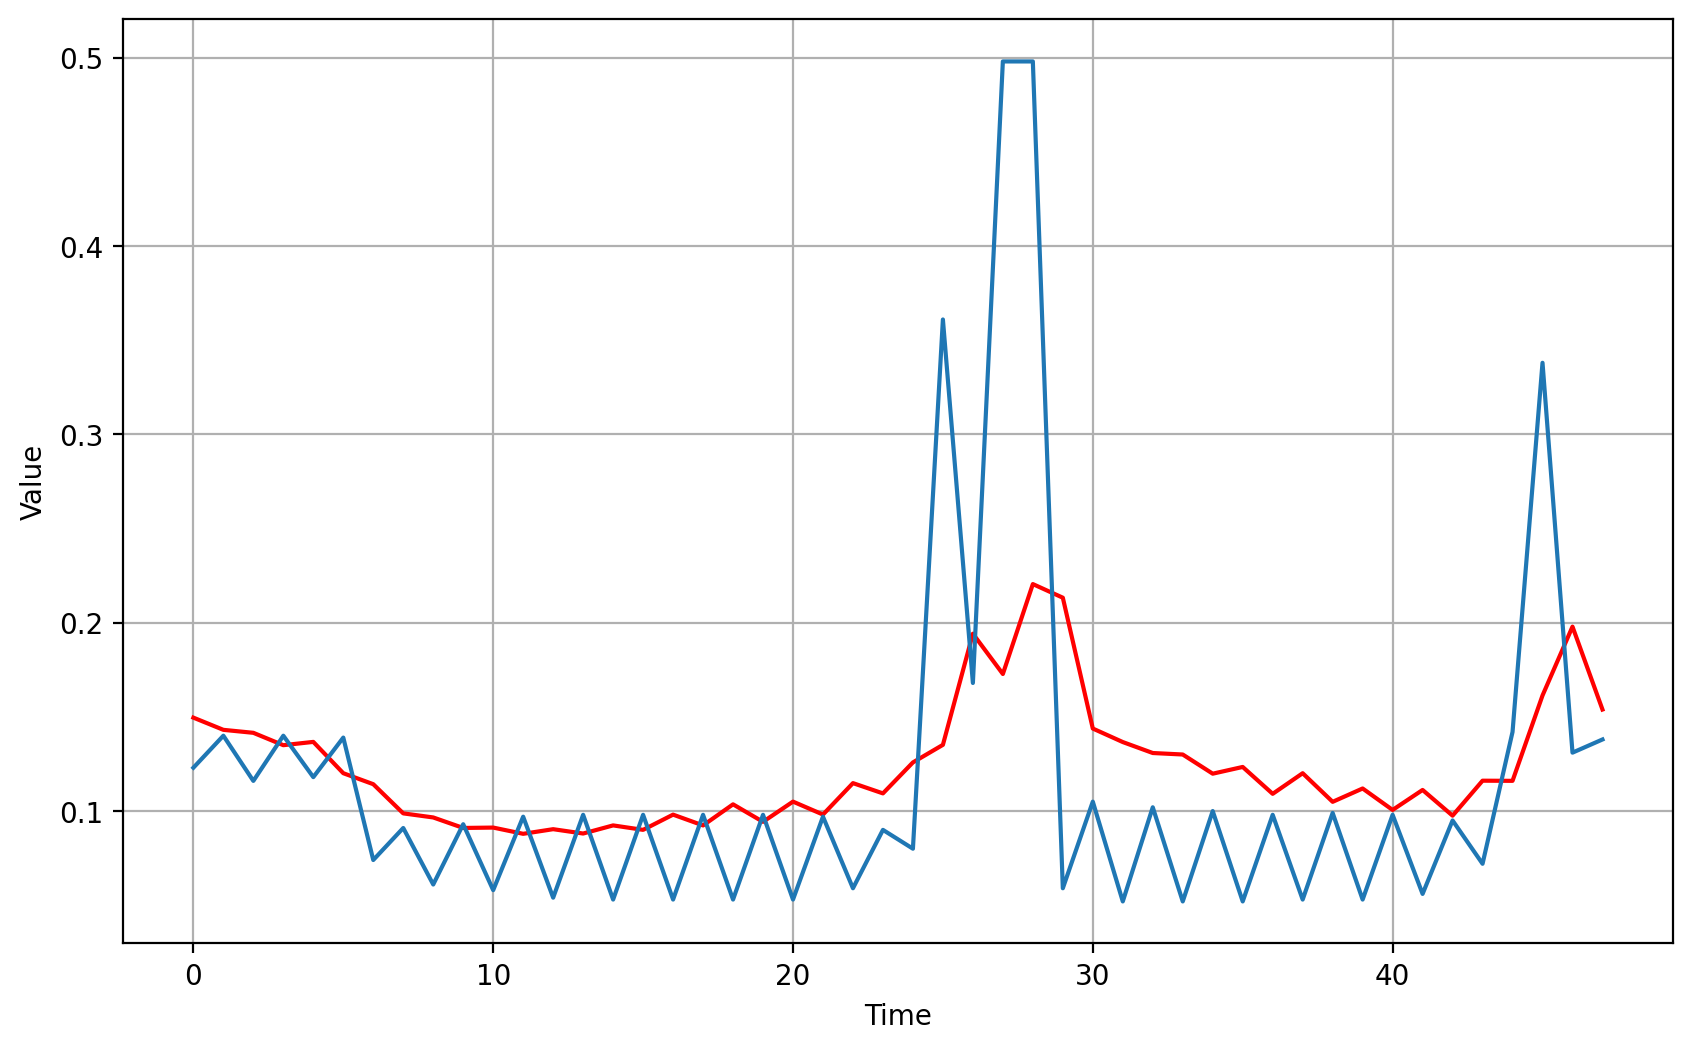

In [29]:
time_plot = range(0, 48)
plt.figure(figsize=(10, 6))
plot_series(time_plot, prediciton_fed, color='red')
plot_series(time_plot, sample['y'])

## Centralized Models

In [30]:
x_central, y_central = create_dataset_central(train_raw[0], time_step)
x_test, y_test = create_dataset_central(test_raw[0], time_step)

In [31]:
model_central = create_DNN()
adam = keras.optimizers.Adam(learning_rate=0.001)
model_central.compile(loss='mse', optimizer=adam, metrics=['mse'])

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model_central.fit(
   x=x_central,
   y=y_central,
   batch_size=batch_size,
   epochs=500,
   callbacks=[callback],
   shuffle=True,
   verbose=0,
)

In [33]:
a = model_central.predict(x_test)

160/160 [==============================] - 0s 527us/step


In [34]:
print(f"MSE: {mean_squared_error(a, y_test)}")
print(f"R2: {r2_score(y_test, a)}")

MSE: 0.004965735733685342
R2: 0.46785529637097056


In [35]:
prediction_central = a[0:48]


In [36]:
print(f"MSE_central: {mean_squared_error(prediction_central, y_test[0:48])}")
print(f"R2_central: {r2_score(y_test[0:48], prediction_central)}")

MSE_central: 0.005438941560396424
R2_central: 0.449283750813095


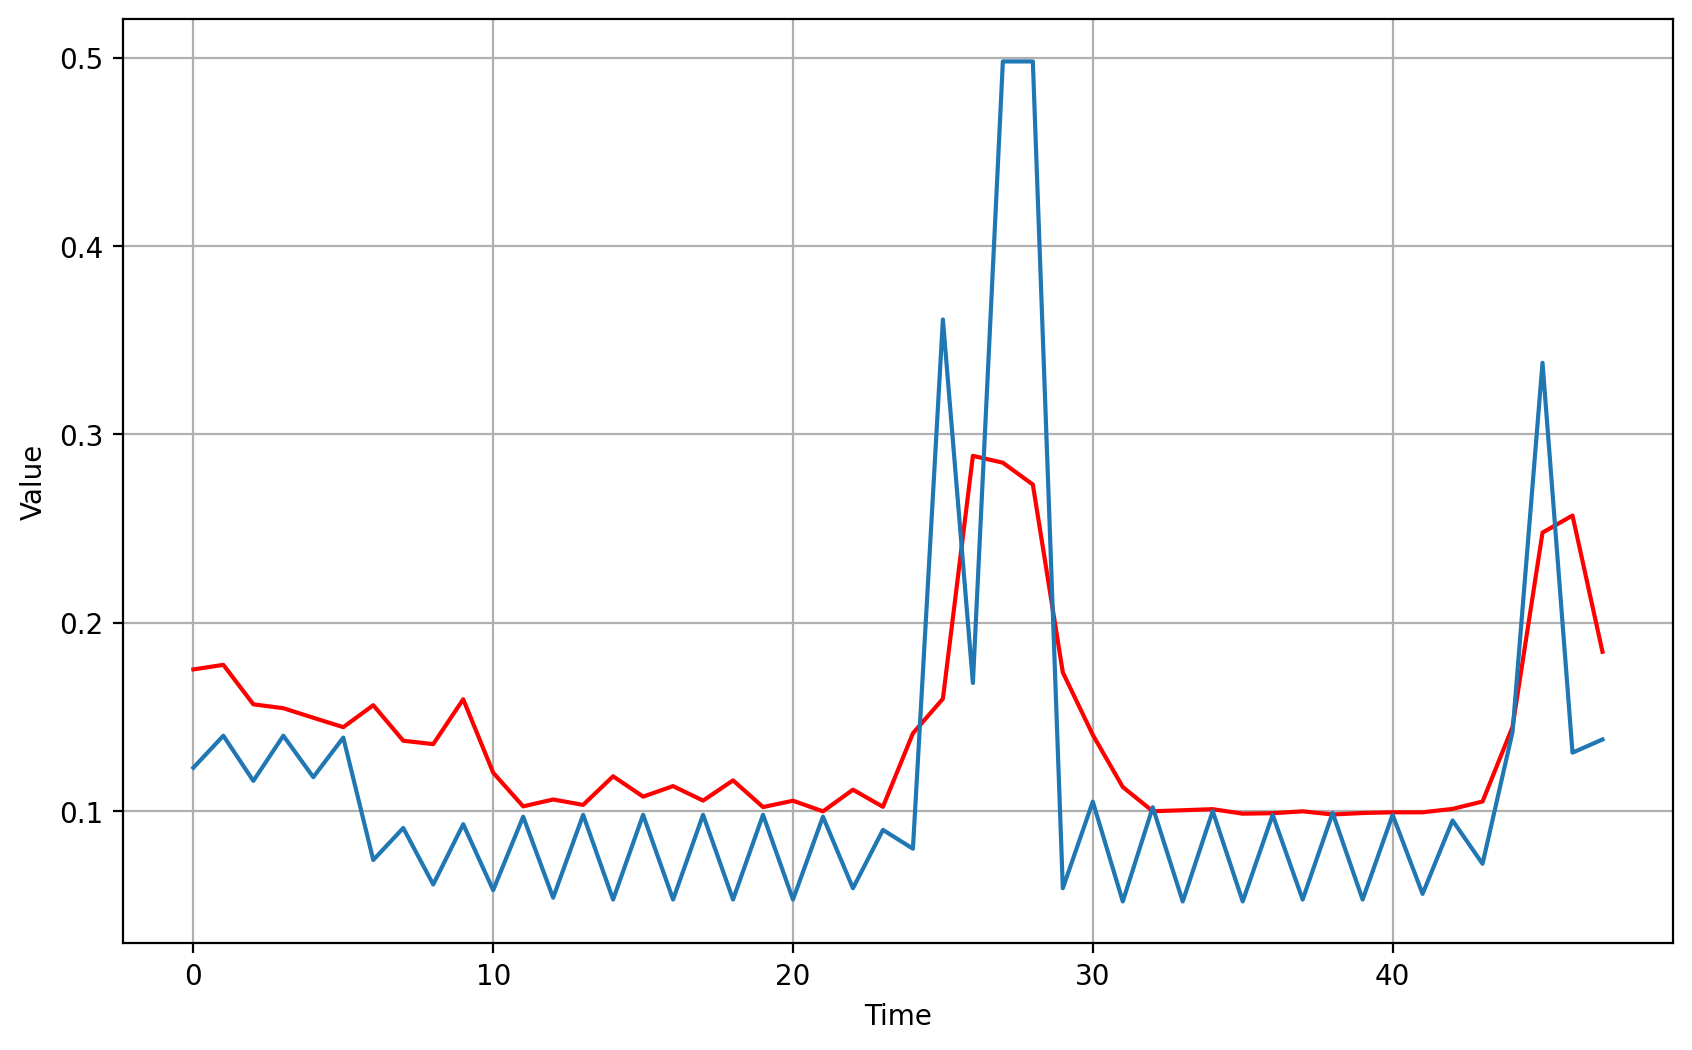

In [37]:
time_plot = range(0, 48)
plt.figure(figsize=(10, 6))
plot_series(time_plot, prediction_central, color='red')
plot_series(time_plot, y_test[0:48])

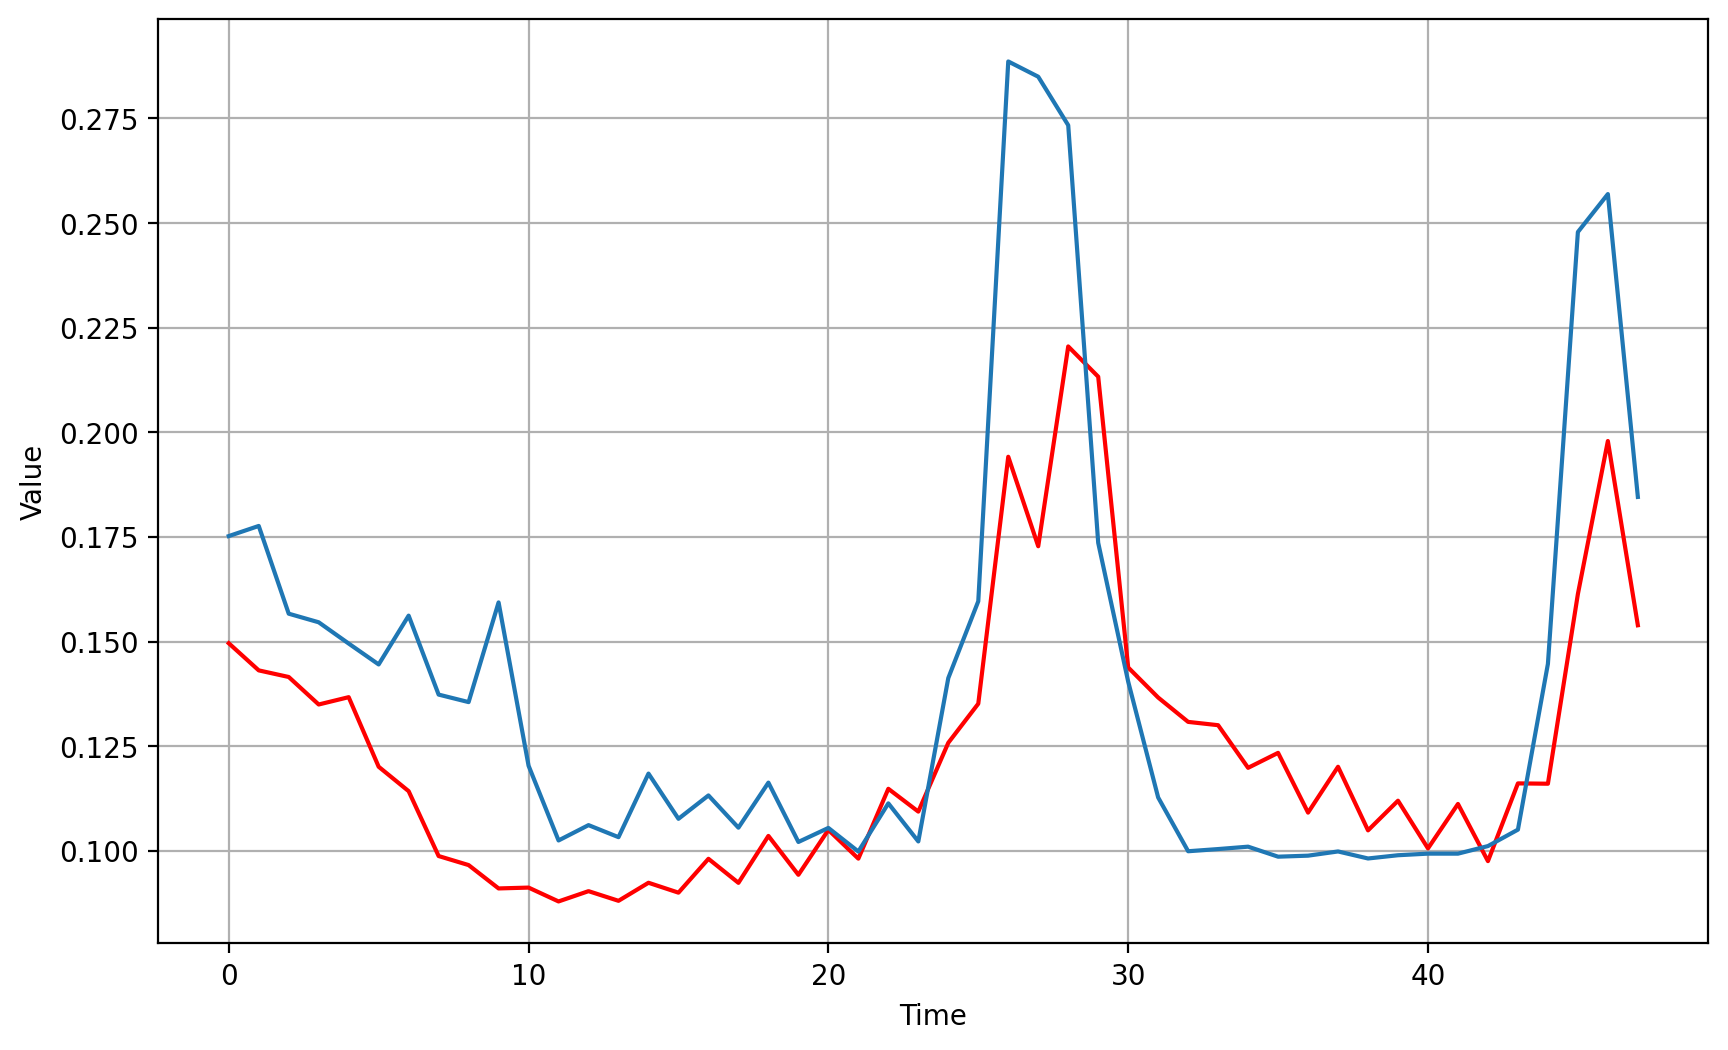

In [38]:
time_plot = range(0, 48)
plt.figure(figsize=(10, 6))
plot_series(time_plot, prediciton_fed, color='red')
plot_series(time_plot, prediction_central)

# 30 self-trained DNN

In [39]:
xx = [[] for i in range(30)]
yy = [[] for i in range(30)]
xx_test = [[] for i in range(30)]
yy_test = [[] for i in range(30)]

for i in range(0, 30):
  xx[i], yy[i] = create_dataset_central(train_raw[i], time_step)
  xx_test[i], yy_test[i] = create_dataset_central(test_raw[i], time_step)
  

In [40]:
def model_loop(train, target, test):
  model_l = create_DNN()
  adam = keras.optimizers.Adam(learning_rate=0.001)
  model_l.compile(loss='mse', optimizer=adam, metrics=['mse'])
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
  model_l.fit(
   x=train,
   y=target,
   batch_size=batch_size,
   epochs=500,
   callbacks=[callback],
   shuffle=True,
   verbose=0,)
  return model_l.predict(test)

In [41]:
l = [[] for i in range(30)]
MSE_cen = [[] for i in range(30)]
R2_cen = [[] for i in range(30)]

start_time = time.time()

for i in range(0, 30):
  l[i] = model_loop(xx[i], yy[i], xx_test[i])
  MSE_cen[i] = mean_squared_error(yy_test[i], l[i])
  R2_cen[i] = r2_score(yy_test[i], l[i])
  print('client {:2d}, metrics={}'.format(i , MSE_cen[i]))

end_time = time.time()
train_time_cen = end_time - start_time
print(train_time_cen)

160/160 [==============================] - 0s 556us/step
client  0, metrics=0.005662326269944128
160/160 [==============================] - 0s 561us/step
client  1, metrics=0.004312586628437367
160/160 [==============================] - 0s 543us/step
client  2, metrics=0.00816254695406785
160/160 [==============================] - 0s 532us/step
client  3, metrics=0.0065539449121754
160/160 [==============================] - 0s 581us/step
client  4, metrics=0.012297648767449461
160/160 [==============================] - 0s 557us/step
client  5, metrics=0.012549871816078195
160/160 [==============================] - 0s 546us/step
client  6, metrics=0.007495167009192101
160/160 [==============================] - 0s 539us/step
client  7, metrics=0.002061769665152515
160/160 [==============================] - 0s 538us/step
client  8, metrics=0.00478654628233726
160/160 [==============================] - 0s 516us/step
client  9, metrics=0.007953229207104184
160/160 [=========================

In [42]:
print("average MSE:", np.mean(MSE_cen))

average MSE: 0.0071657161975581364


In [43]:
print("average MSE:", np.mean(MSE_cen))
worst = max(MSE_cen)
worst_id = MSE_cen.index(worst)
print("worst performance self model:", worst_id, "|| MSE = ", worst)
best = min(MSE_cen)
best_id = MSE_cen.index(best)
print("best performance self model:", best_id, "|| MSE = ", best)

average MSE: 0.0071657161975581364
worst performance self model: 5 || MSE =  0.012549871816078195
best performance self model: 7 || MSE =  0.002061769665152515


# worst

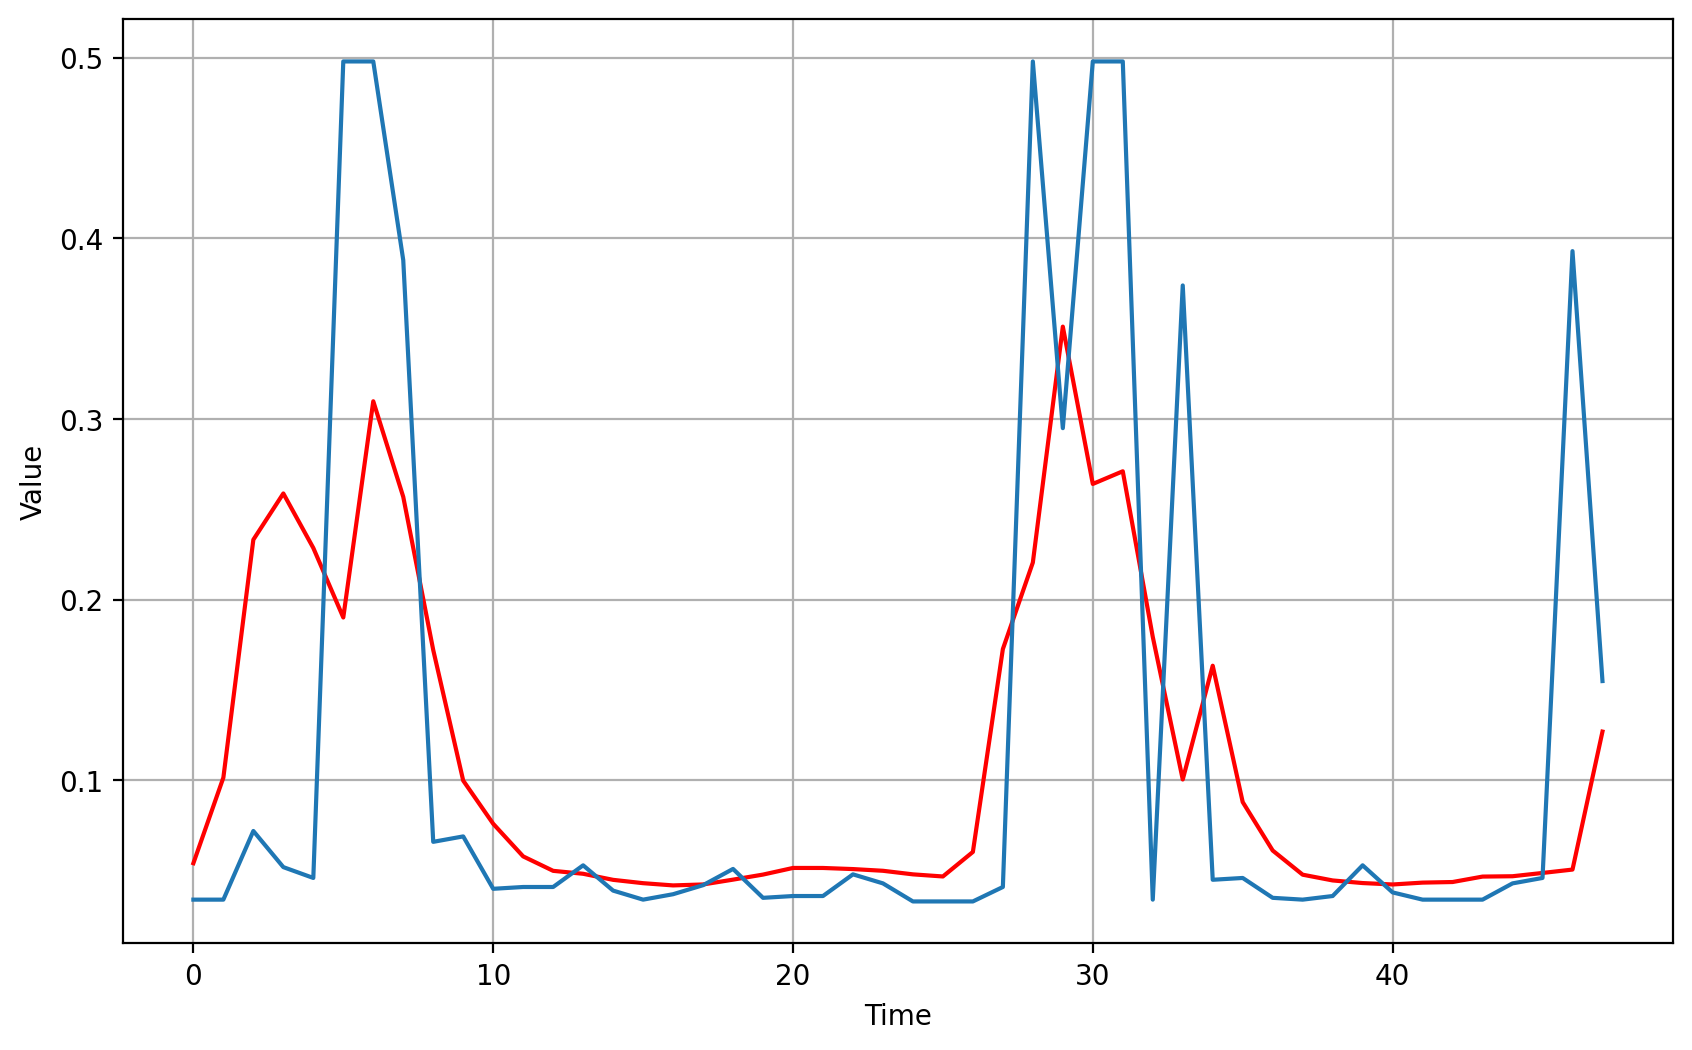

In [44]:
predict_worst = l[worst_id][0:48]
plt.figure(figsize=(10, 6))
plot_series(time_plot, predict_worst, color='red')
plot_series(time_plot, yy_test[worst_id][0:48])

In [45]:
predict_fed_worst = model_fed.predict(xx_test[worst_id])
print(f"MSE_fed: {mean_squared_error(predict_fed_worst, yy_test[worst_id])}")
print(f"R2_fed: {r2_score(yy_test[worst_id], predict_fed_worst)}")

160/160 [==============================] - 0s 620us/step
MSE_fed: 0.013492470398796946
R2_fed: 0.300409240030041


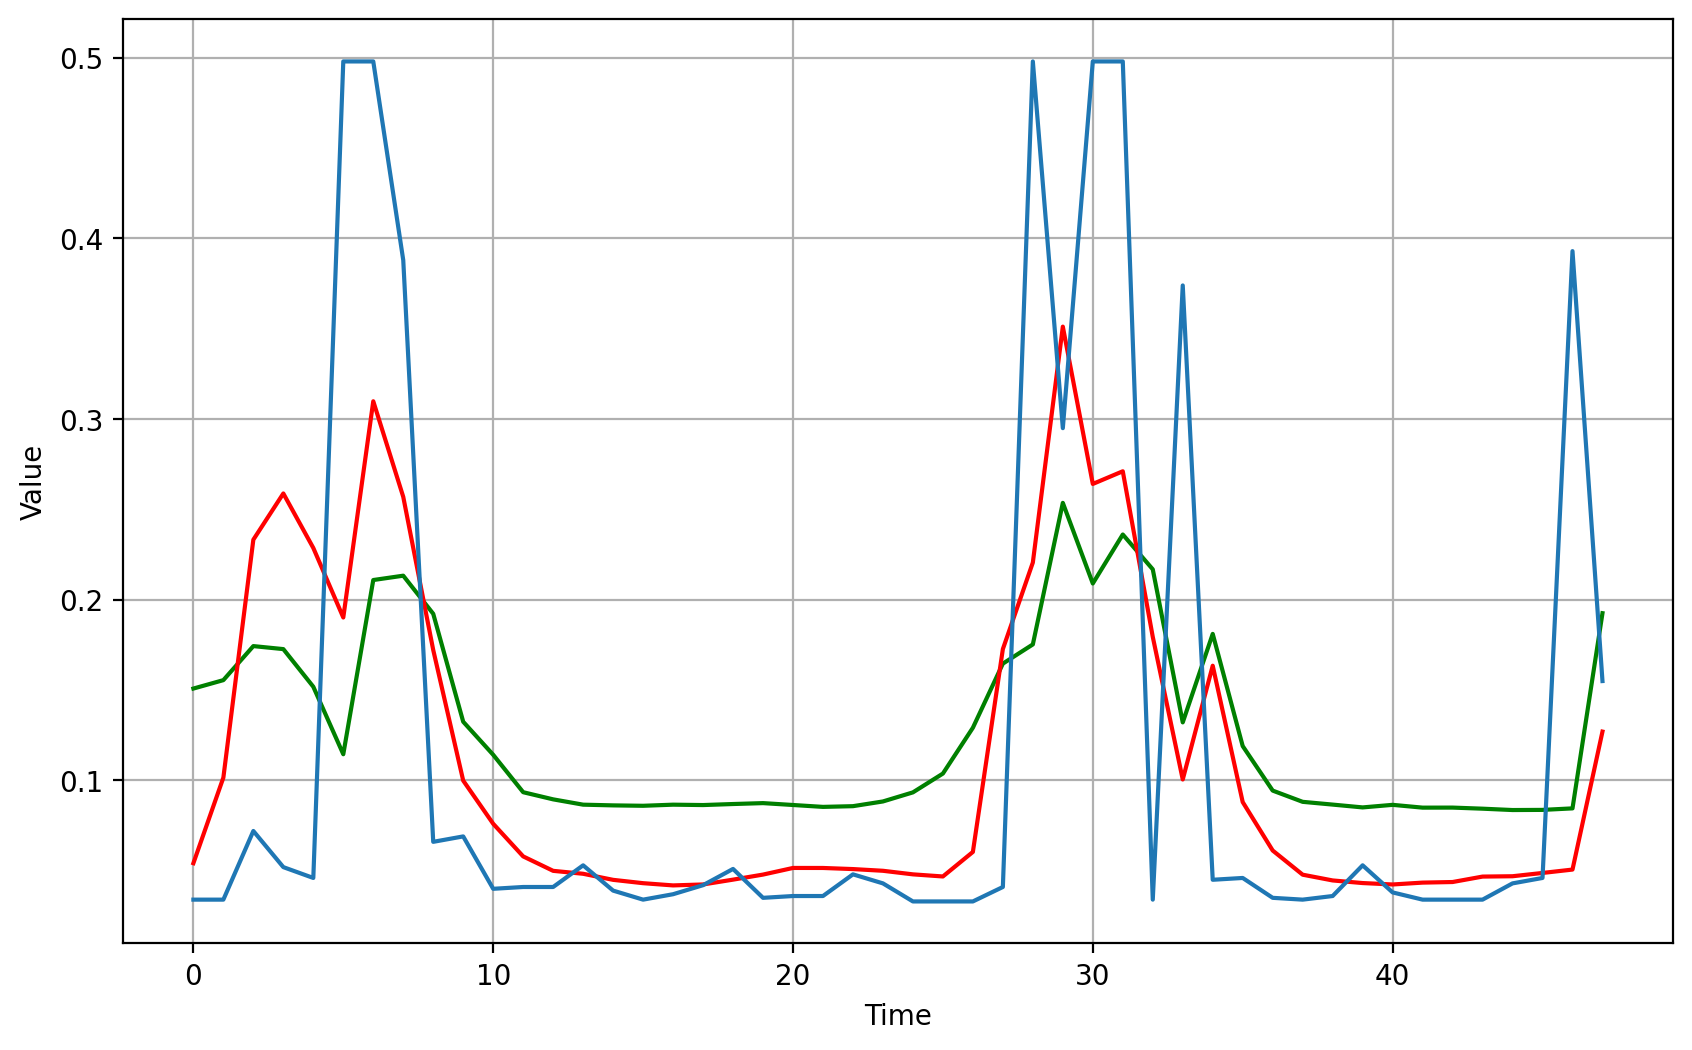

In [46]:
plt.figure(figsize=(10, 6))
plot_series(time_plot, predict_fed_worst[0:48], color='green')
plot_series(time_plot, predict_worst, color='red')
plot_series(time_plot, yy_test[worst_id][0:48])

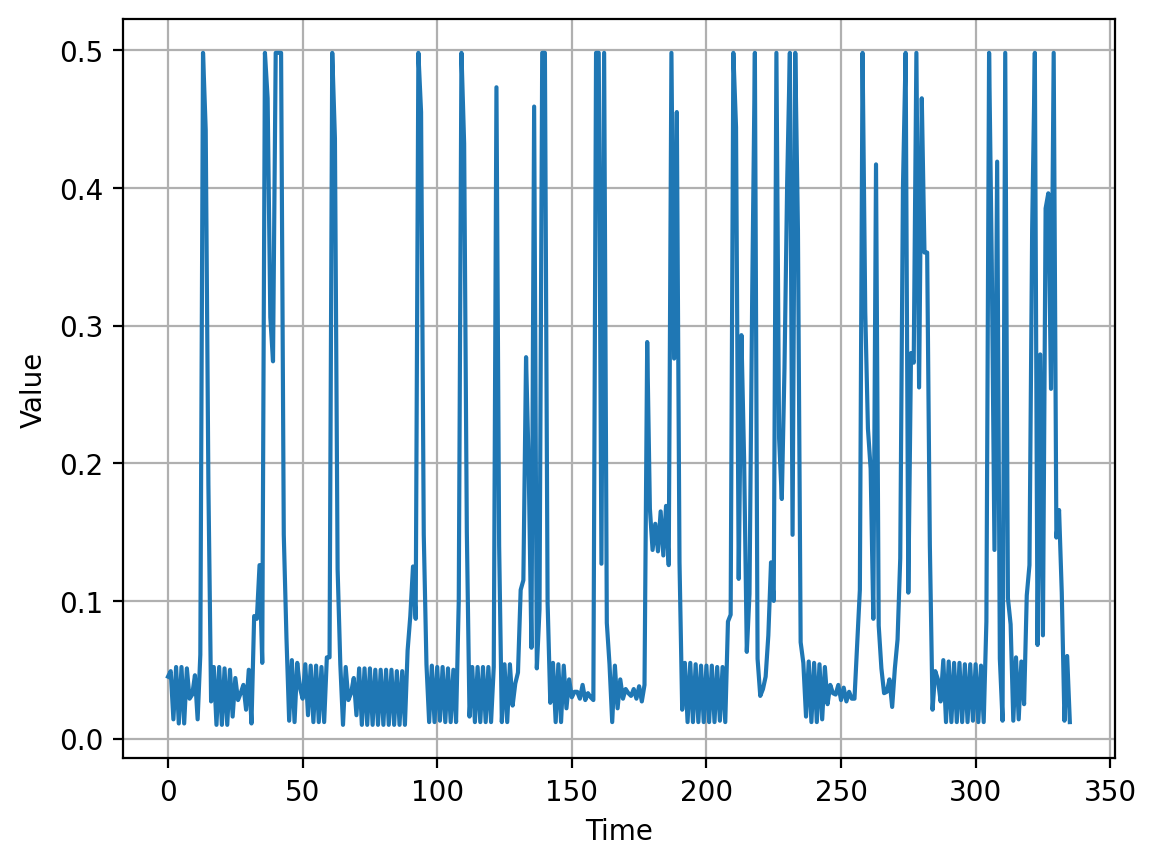

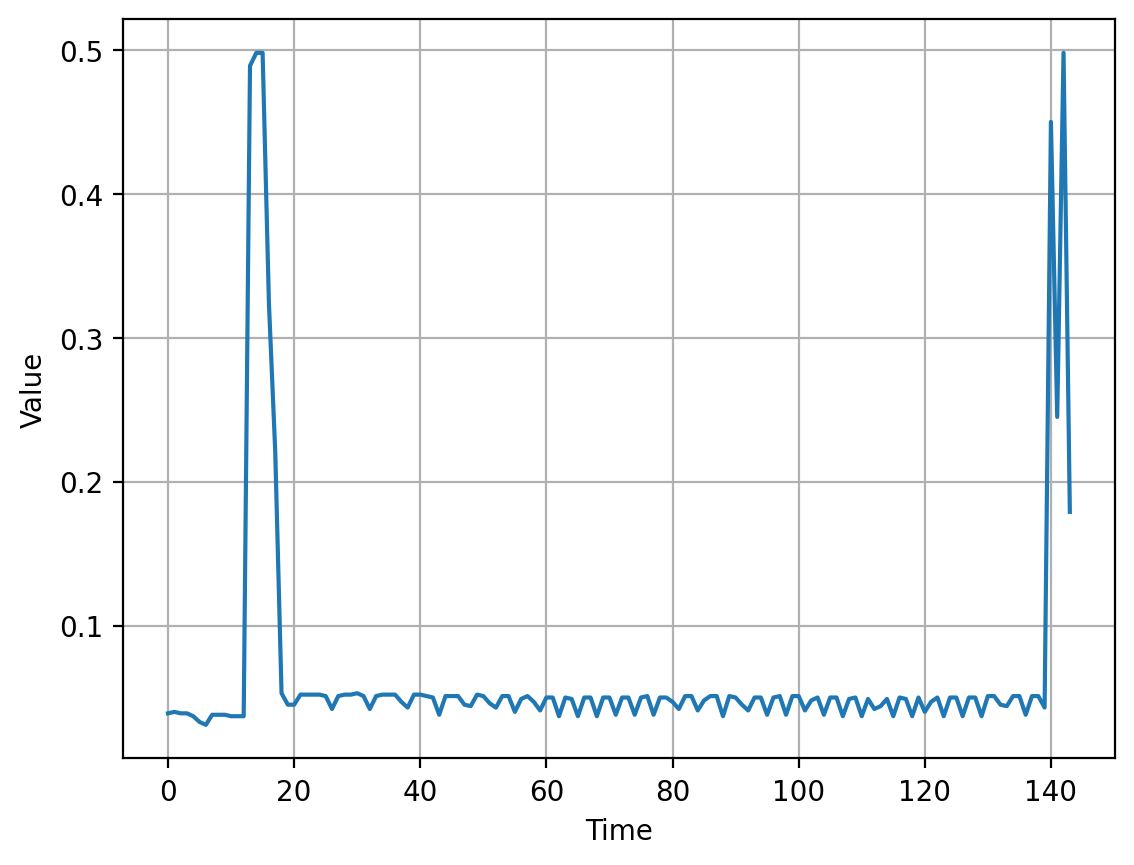

In [47]:
sample_worst_week = consumption[worst_id][48*7*30: 48*7*31]
plot_series(range(len(sample_worst_week)), sample_worst_week)
plt.show()
plt.clf()
sample_worst_3day = consumption[worst_id][48*3*100: 48*3*101]
plot_series(range(len(sample_worst_3day)), sample_worst_3day)



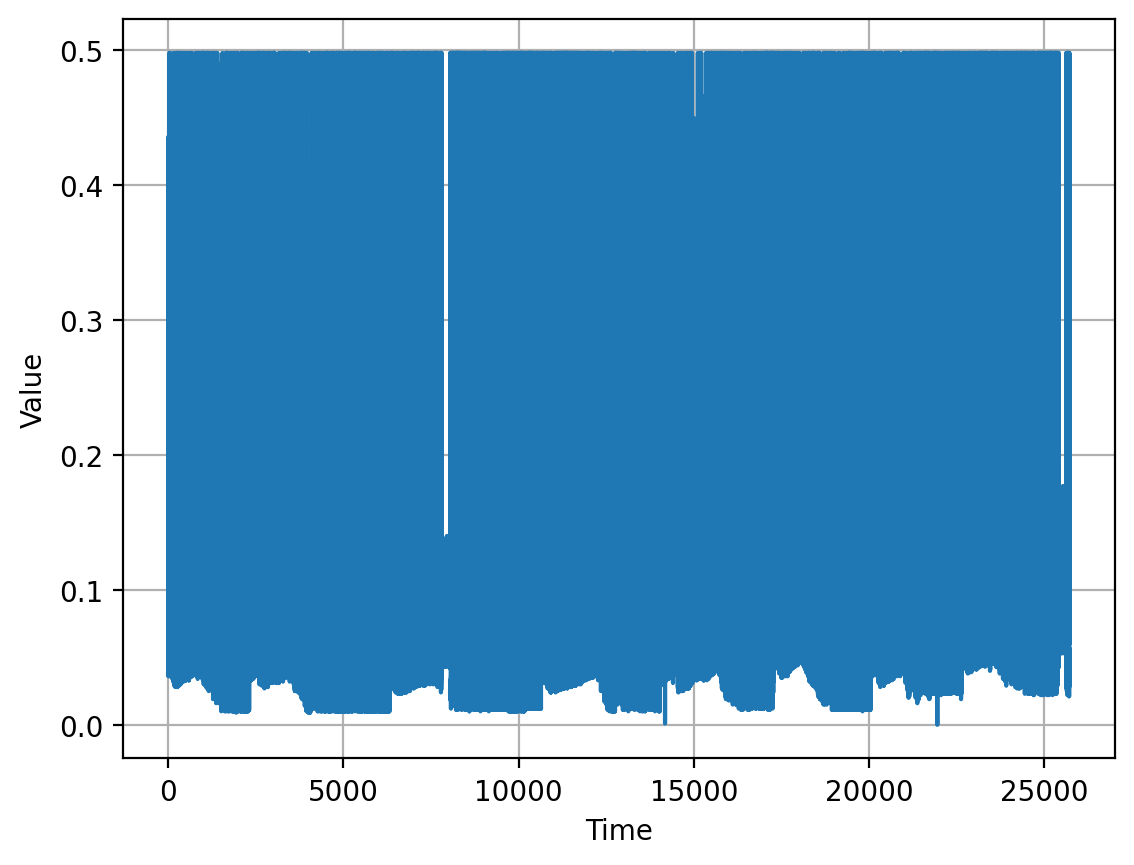

In [48]:
plot_series(range(len(consumption[worst_id])), consumption[worst_id])


# Best

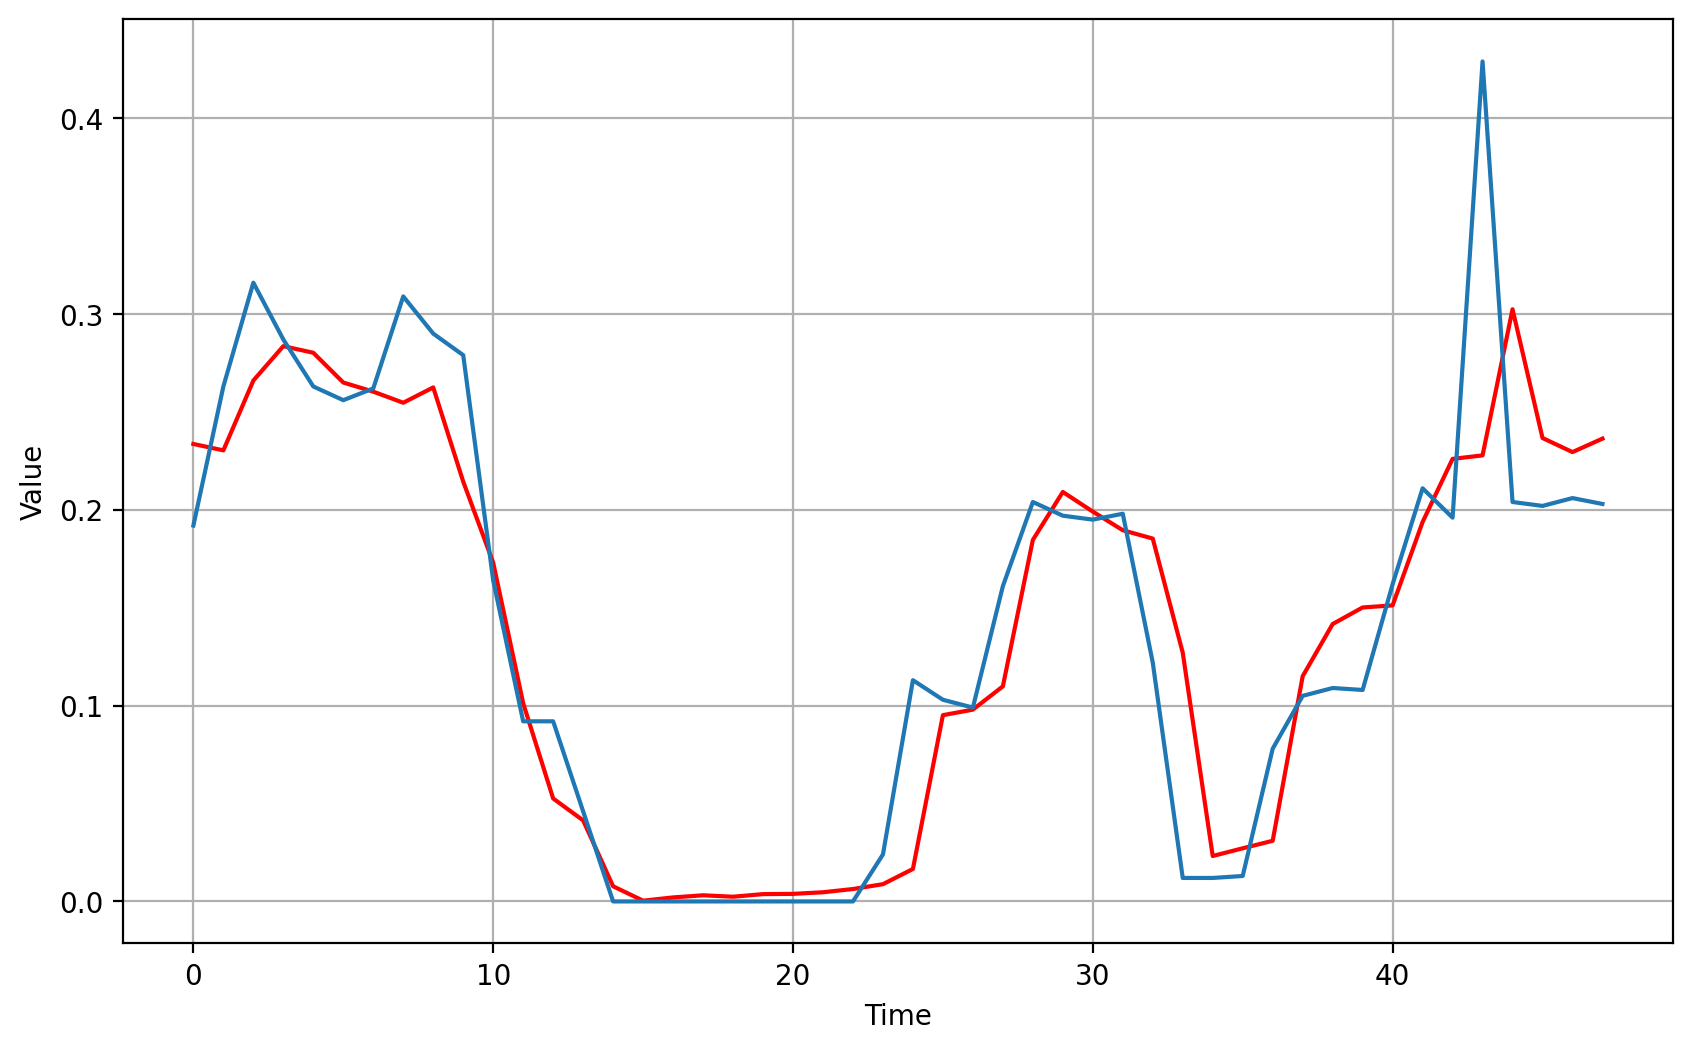

In [49]:
predict_best = l[best_id][0:48]
plt.figure(figsize=(10, 6))
plot_series(time_plot, predict_best, color='red')
plot_series(time_plot, yy_test[best_id][0:48])

In [50]:
predict_fed_best = model_fed.predict(xx_test[best_id])
print(f"MSE_fed: {mean_squared_error(predict_fed_best, yy_test[best_id])}")
print(f"R2_fed: {r2_score(yy_test[best_id], predict_fed_best)}")

160/160 [==============================] - 0s 609us/step
MSE_fed: 0.005071279367196161
R2_fed: 0.5747241087385213


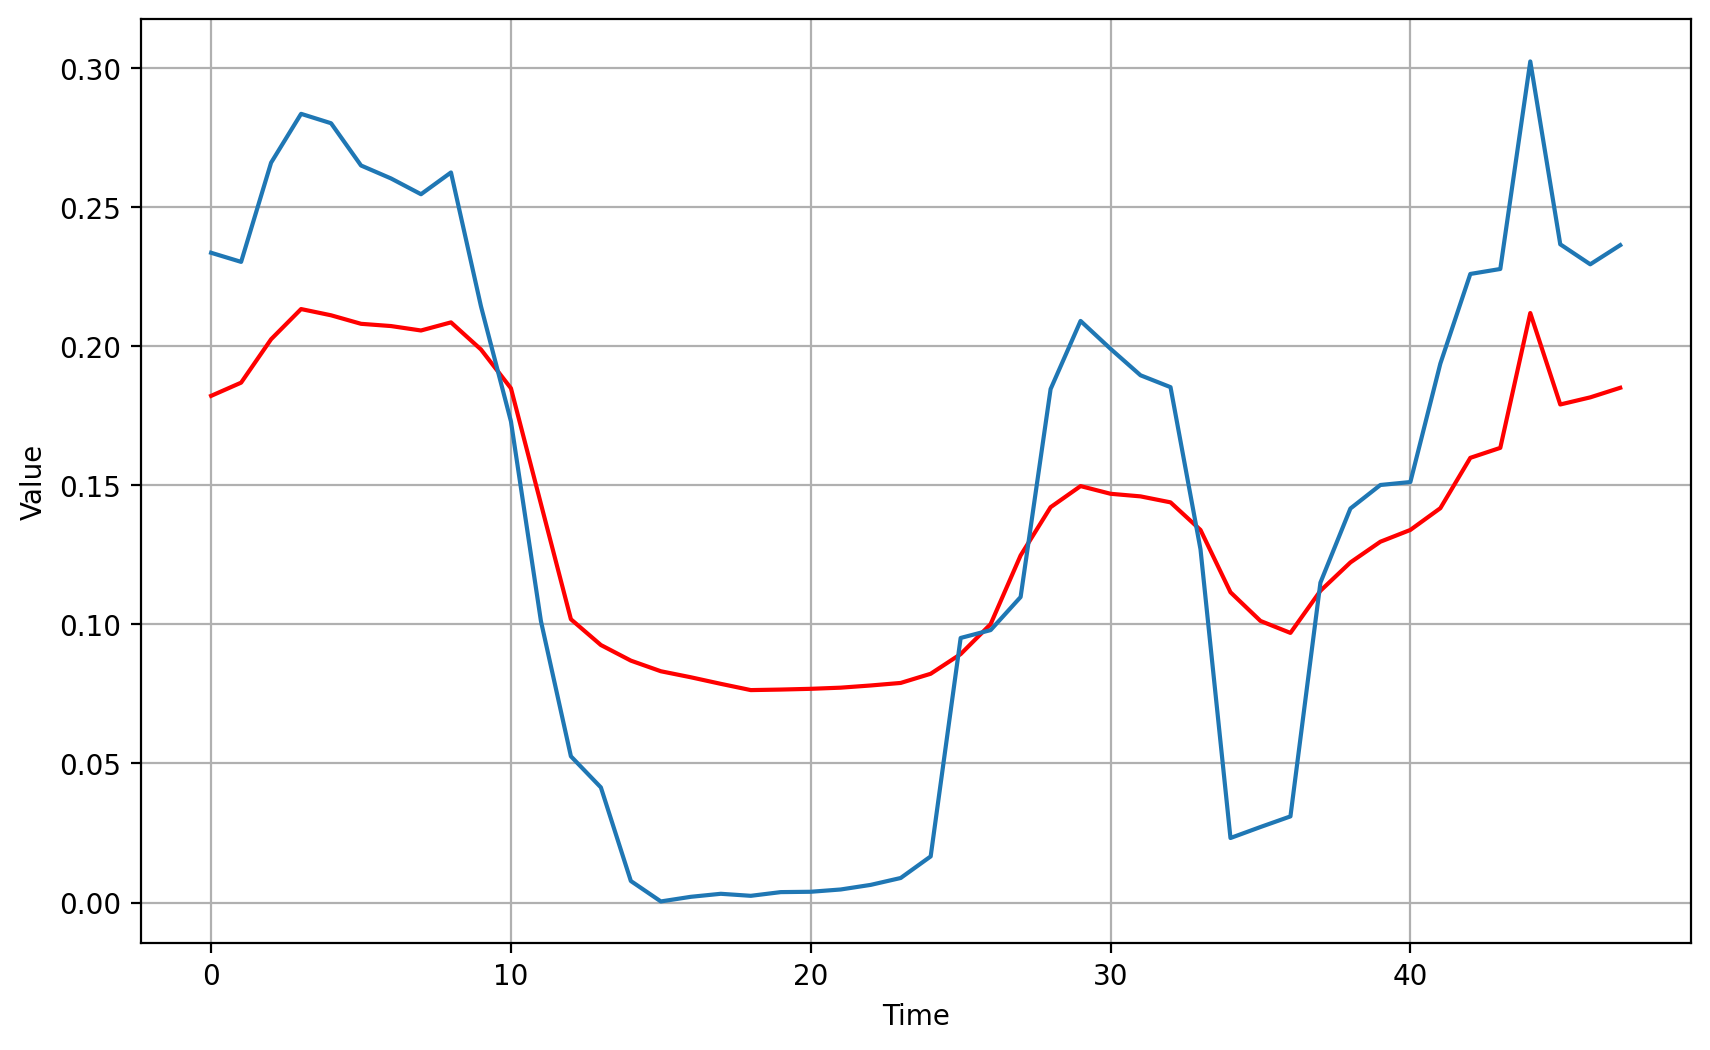

In [51]:
plt.figure(figsize=(10, 6))
plot_series(time_plot, predict_fed_best[0:48], color='red')
plot_series(time_plot, predict_best)

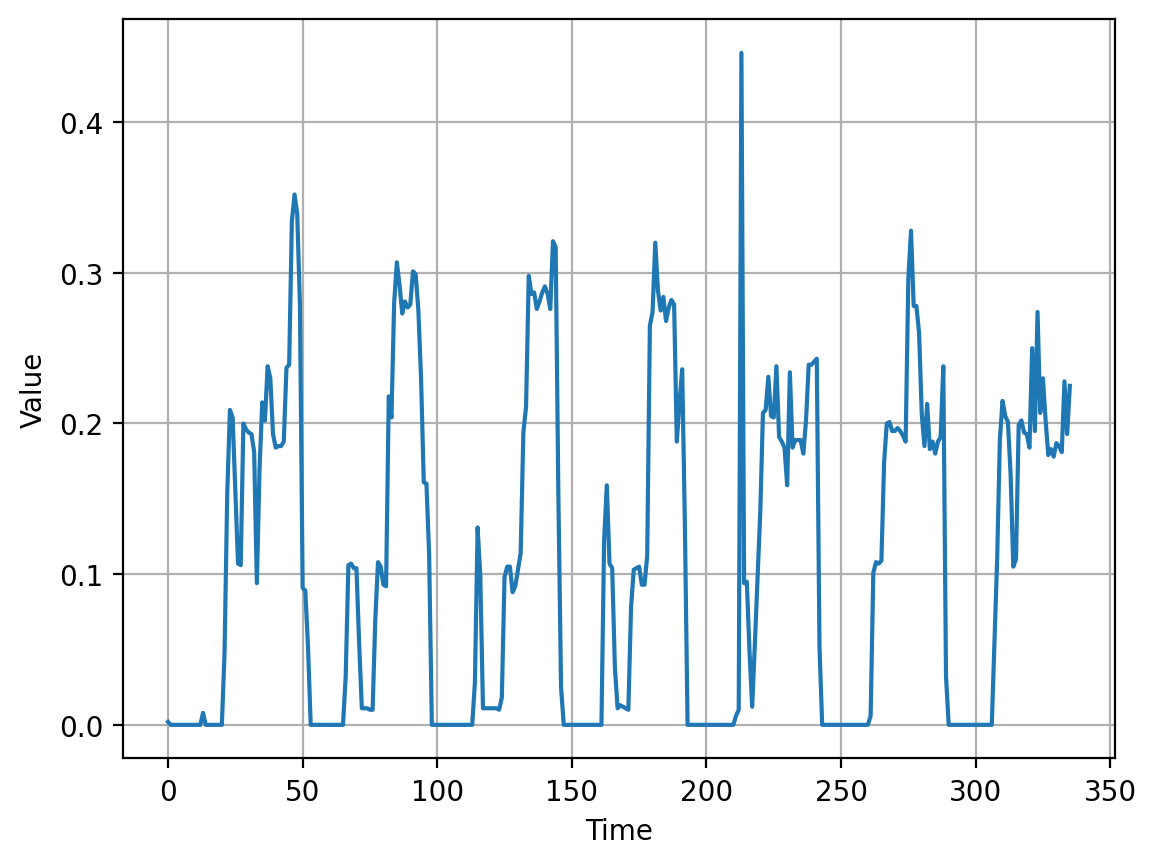

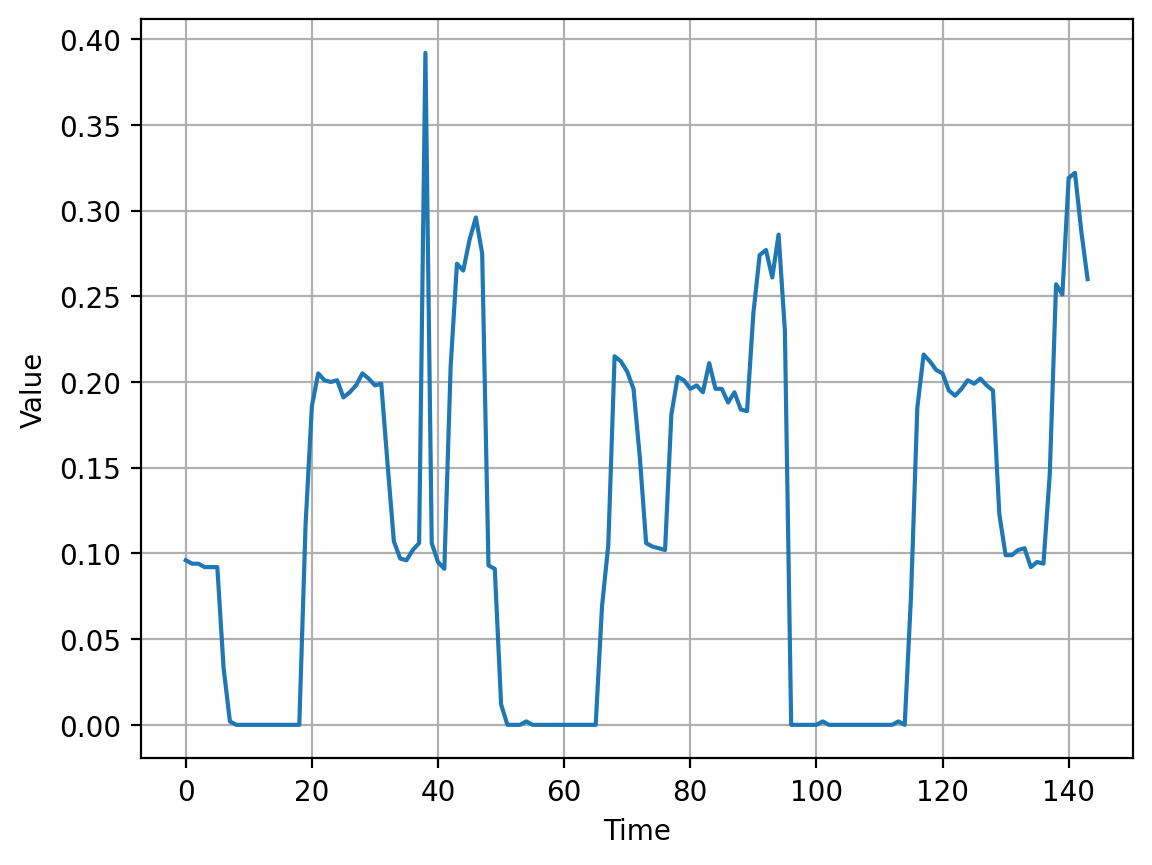

In [52]:
sample_15_week = consumption[best_id][48*7*30: 48*7*31]
plot_series(range(len(sample_15_week)), sample_15_week)
plt.show()
plt.clf()
sample_15_3day = consumption[best_id][48*3*100: 48*3*101]
plot_series(range(len(sample_15_3day)), sample_15_3day)

